In [ ]:
'''
MobileNet v2 - Ablation Implementation

 - Get the OSST table for all networks
 - Grid ablation for other networks
 - MobileNet with 64 grids
 - For the grids save the RDS values, difference as well as seperate template matches

'''

# Imports

In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Change


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
import tensorflow as tf
from keras import backend as K
#K.set_image_dim_ordering('tf')
from keras_applications import imagenet_utils as utils
from keras_applications import correct_pad
from keras.layers import Lambda

from scipy import stats
import PIL.Image
import seaborn as sns
import gc
# import innvestigate
# import innvestigate.utils
# from vis.utils import utils as vis_utils
from keras.preprocessing.image import load_img, img_to_array
#}

Using TensorFlow backend.


# Model Definition

In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
'''
Cells 3 and 4 are focused on defining the MobileNetV2 architecture with Lambda layers for 
Ablation
'''
debug = False
backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils
keras.backend.image_data_format() #Make sure image matrix in expected orientation

'channels_last'

In [4]:
"""MobileNet v2 models for Keras.

MobileNetV2 is a general architecture and can be used for multiple use cases.
Depending on the use case, it can use different input layer size and
different width factors. This allows different width models to reduce
the number of multiply-adds and thereby
reduce inference cost on mobile devices.

MobileNetV2 is very similar to the original MobileNet,
except that it uses inverted residual blocks with
bottlenecking features. It has a drastically lower
parameter count than the original MobileNet.
MobileNets support any input size greater
than 32 x 32, with larger image sizes
offering better performance.

The number of parameters and number of multiply-adds
can be modified by using the `alpha` parameter,
which increases/decreases the number of filters in each layer.
By altering the image size and `alpha` parameter,
all 22 models from the paper can be built, with ImageNet weights provided.

The paper demonstrates the performance of MobileNets using `alpha` values of
1.0 (also called 100 % MobileNet), 0.35, 0.5, 0.75, 1.0, 1.3, and 1.4

For each of these `alpha` values, weights for 5 different input image sizes
are provided (224, 192, 160, 128, and 96).


The following table describes the performance of
MobileNet on various input sizes:
------------------------------------------------------------------------
MACs stands for Multiply Adds

 Classification Checkpoint| MACs (M) | Parameters (M)| Top 1 Accuracy| Top 5 Accuracy
--------------------------|------------|---------------|---------|----|-------------
| [mobilenet_v2_1.4_224]  | 582 | 6.06 |          75.0 | 92.5 |
| [mobilenet_v2_1.3_224]  | 509 | 5.34 |          74.4 | 92.1 |
| [mobilenet_v2_1.0_224]  | 300 | 3.47 |          71.8 | 91.0 |
| [mobilenet_v2_1.0_192]  | 221 | 3.47 |          70.7 | 90.1 |
| [mobilenet_v2_1.0_160]  | 154 | 3.47 |          68.8 | 89.0 |
| [mobilenet_v2_1.0_128]  | 99  | 3.47 |          65.3 | 86.9 |
| [mobilenet_v2_1.0_96]   | 56  | 3.47 |          60.3 | 83.2 |
| [mobilenet_v2_0.75_224] | 209 | 2.61 |          69.8 | 89.6 |
| [mobilenet_v2_0.75_192] | 153 | 2.61 |          68.7 | 88.9 |
| [mobilenet_v2_0.75_160] | 107 | 2.61 |          66.4 | 87.3 |
| [mobilenet_v2_0.75_128] | 69  | 2.61 |          63.2 | 85.3 |
| [mobilenet_v2_0.75_96]  | 39  | 2.61 |          58.8 | 81.6 |
| [mobilenet_v2_0.5_224]  | 97  | 1.95 |          65.4 | 86.4 |
| [mobilenet_v2_0.5_192]  | 71  | 1.95 |          63.9 | 85.4 |
| [mobilenet_v2_0.5_160]  | 50  | 1.95 |          61.0 | 83.2 |
| [mobilenet_v2_0.5_128]  | 32  | 1.95 |          57.7 | 80.8 |
| [mobilenet_v2_0.5_96]   | 18  | 1.95 |          51.2 | 75.8 |
| [mobilenet_v2_0.35_224] | 59  | 1.66 |          60.3 | 82.9 |
| [mobilenet_v2_0.35_192] | 43  | 1.66 |          58.2 | 81.2 |
| [mobilenet_v2_0.35_160] | 30  | 1.66 |          55.7 | 79.1 |
| [mobilenet_v2_0.35_128] | 20  | 1.66 |          50.8 | 75.0 |
| [mobilenet_v2_0.35_96]  | 11  | 1.66 |          45.5 | 70.4 |

The weights for all 16 models are obtained and
translated from the Tensorflow checkpoints
from TensorFlow checkpoints found [here]
(https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/README.md).

# Reference

This file contains building code for MobileNetV2, based on
[MobileNetV2: Inverted Residuals and Linear Bottlenecks]
(https://arxiv.org/abs/1801.04381) (CVPR 2018)

Tests comparing this model to the existing Tensorflow model can be
found at [mobilenet_v2_keras]
(https://github.com/JonathanCMitchell/mobilenet_v2_keras)
"""
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import warnings
import numpy as np

# TODO Change path to v1.1
BASE_WEIGHT_PATH = ('https://github.com/JonathanCMitchell/mobilenet_v2_keras/'
                    'releases/download/v1.1/')

backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils


def preprocess_input(x, **kwargs):
    """Preprocesses a numpy array encoding a batch of images.

    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].

    # Returns
        Preprocessed array.
    """
    return utils.preprocess_input(x, mode='tf', **kwargs)


# This function is taken from the original tf repo.
# It ensures that all layers have a channel number that is divisible by 8
# It can be seen here:
# https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def MobileNetV2(input_shape=None,
                alpha=1.0,
                include_top=True,
                weights='imagenet',
                input_tensor=None,
                pooling=None,
                classes=1000,
                lambda_mask = None,
                **kwargs):
    """Instantiates the MobileNetV2 architecture.

    # Arguments
        input_shape: optional shape tuple, to be specified if you would
            like to use a model with an input img resolution that is not
            (224, 224, 3).
            It should have exactly 3 inputs channels (224, 224, 3).
            You can also omit this option if you would like
            to infer input_shape from an input_tensor.
            If you choose to include both input_tensor and input_shape then
            input_shape will be used if they match, if the shapes
            do not match then we will throw an error.
            E.g. `(160, 160, 3)` would be one valid value.
        alpha: controls the width of the network. This is known as the
        width multiplier in the MobileNetV2 paper, but the name is kept for
        consistency with MobileNetV1 in Keras.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of
            `layers.Input()`)
            to use as image input for the model.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape or invalid alpha, rows when
            weights='imagenet'
    """
    global backend, layers, models, keras_utils, debug
    #debug = True
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` '
                         'as true, `classes` should be 1000')

    # Determine proper input shape and default size.
    # If both input_shape and input_tensor are used, they should match
    if input_shape is not None and input_tensor is not None:
        try:
            is_input_t_tensor = backend.is_keras_tensor(input_tensor)
        except ValueError:
            try:
                is_input_t_tensor = backend.is_keras_tensor(
                    keras_utils.get_source_inputs(input_tensor))
            except ValueError:
                raise ValueError('input_tensor: ', input_tensor,
                                 'is not type input_tensor')
        if is_input_t_tensor:
            if backend.image_data_format == 'channels_first':
                if backend.int_shape(input_tensor)[1] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
            else:
                if backend.int_shape(input_tensor)[2] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
        else:
            raise ValueError('input_tensor specified: ', input_tensor,
                             'is not a keras tensor')

    # If input_shape is None, infer shape from input_tensor
    if input_shape is None and input_tensor is not None:

        try:
            backend.is_keras_tensor(input_tensor)
        except ValueError:
            raise ValueError('input_tensor: ', input_tensor,
                             'is type: ', type(input_tensor),
                             'which is not a valid type')

        if input_shape is None and not backend.is_keras_tensor(input_tensor):
            default_size = 224
        elif input_shape is None and backend.is_keras_tensor(input_tensor):
            if backend.image_data_format() == 'channels_first':
                rows = backend.int_shape(input_tensor)[2]
                cols = backend.int_shape(input_tensor)[3]
            else:
                rows = backend.int_shape(input_tensor)[1]
                cols = backend.int_shape(input_tensor)[2]

            if rows == cols and rows in [96, 128, 160, 192, 224]:
                default_size = rows
            else:
                default_size = 224

    # If input_shape is None and no input_tensor
    elif input_shape is None:
        default_size = 224

    # If input_shape is not None, assume default size
    else:
        if backend.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [96, 128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    input_shape = utils._obtain_input_shape(input_shape,
                                      default_size=default_size,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if backend.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if alpha not in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of `0.35`, `0.50`, `0.75`, '
                             '`1.0`, `1.3` or `1.4` only.')

        if rows != cols or rows not in [96, 128, 160, 192, 224]:
            rows = 224
            warnings.warn('`input_shape` is undefined or non-square, '
                          'or `rows` is not in [96, 128, 160, 192, 224].'
                          ' Weights for input shape (224, 224) will be'
                          ' loaded as the default.')

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = layers.ZeroPadding2D(padding=correct_pad(backend, img_input, 3),
                             name='Conv1_pad')(img_input)
    x = layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    global start_index, end_index
    start_index = end_index = 0
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (default_size//2 * default_size//2 * first_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (default_size//2, default_size//2, first_block_filters))
        if debug:
            print('Conv_1',start_index,end_index)
    else:
        x_mask = np.ones(shape=((default_size//2, default_size//2, first_block_filters)))

    x_mask  = backend.variable(x_mask) #Numpy array to Tensor
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (default_size//2 * default_size//2 * first_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (default_size//2, default_size//2, first_block_filters))
        if debug:
            print('Conv_1_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((default_size//2, default_size//2, first_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16, lambda_mask=lambda_mask)

    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (x.shape[1] * x.shape[2]* last_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (x.shape[1], x.shape[2], last_block_filters))
        if debug:
            print('Conv_1',start_index,end_index)
    else:
        x_mask = np.ones(shape=((x.shape[1], x.shape[2], last_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (x.shape[1] * x.shape[2] * last_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (x.shape[1], x.shape[2], last_block_filters))
        if debug:
            print('Conv_1_bn',start_index,end_index)
    else:
        x_mask = np.ones(shape=((x.shape[1],x.shape[2], last_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.ReLU(6., name='out_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(classes, activation='softmax', use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name='mobilenetv2_%0.2f_%s' % (alpha, rows))

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' + str(alpha) + '_' + str(rows) + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        else:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' + str(alpha) + '_' + str(rows) + '_no_top' + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, lambda_mask = None):
    global debug
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    in_channels = backend.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)
    #print(prefix, inputs.shape,inputs.shape[0],inputs.shape[1] , in_channels, pointwise_conv_filters, pointwise_filters, filters)
    global start_index, end_index
    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (inputs.shape[1] * inputs.shape[2] * inputs.shape[3]*expansion)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion))
            if debug:
                print(prefix + 'expand',start_index,end_index)
        else:
            x_mask = np.ones(shape=((inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################
        x = layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
  
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (inputs.shape[1] * inputs.shape[2] * inputs.shape[3]*expansion)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion))
            if debug:
                print(prefix + 'expand_BN',start_index,end_index)
        else:
            x_mask = np.ones(shape=((inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = layers.ZeroPadding2D(padding=correct_pad(backend, x, 3), name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None, use_bias=False,padding='same' if stride == 1 else 'valid', name=prefix + 'depthwise')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * inputs.shape[3]*expansion)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion))
        if debug:
            print(prefix + 'depthwise',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,epsilon=1e-3,momentum=0.999, name=prefix + 'depthwise_BN')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * inputs.shape[3]*expansion)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion))
        if debug:
            print(prefix + 'depthwise_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=False, activation=None, name=prefix + 'project')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * pointwise_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters))
        if debug:
            print(prefix + 'project',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis, epsilon=1e-3, momentum=0.999, name=prefix + 'project_BN')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * pointwise_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters))
        if debug:
            print(prefix + 'project_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x

In [5]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        global backend
        x = preprocess_input(ret, 
            data_format=backend.image_data_format())
        img_list.append(x)


    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [6]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [7]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [8]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

# Step 0 - Getting activations and saving them into pkl files

In [ ]:
# Loading the folder to be procesed from command line{
#Animate/Inanimate
p = 'inanimate' #Change
tmp = p.replace('/','_')
url_path = '../../data/'+p+'/'
print(tmp)

#Output Folder
folder = 'pkl_mobile'
p_num = 1
#}

In [ ]:
# Prepare the image list and pre-process them{
true_wids = []
im_list = []
for i in os.listdir(url_path):
    if not i.startswith('~') and not i.startswith('.'):
        #print i, truth
        temp = i.split('.')[0].split('_')[2]
        true_wids.append(truth[int(temp)][1])
        im_list.append(url_path+i)
print(len(im_list))

In [ ]:
im = preprocess_image_batch(im_list,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

In [ ]:
# Model parmeters and running the model from the loaded weights{


model_name = 'MobileNetV2'
model = MobileNetV2( input_shape=None,
    alpha=0.35,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    lambda_mask = np.ones(5725552),
    classes=1000,
    classifier_activation="softmax")
#KFold
k = 4

im_train, im_test = train_test_split(im_list, test_size=0.25, random_state=42)
#}

In [ ]:
model.summary()

In [ ]:
im_temp = preprocess_image_batch(im_train,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
i = 0
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        print(layer.name, len(weights), weights[0].shape)
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            print(i, len(activations), activations[0].shape)
    i += 1

In [ ]:
#Training data pkl
fp_name = '../../data/pkl_mobile/'+str(p)+'_'+str(model_name)+'_train_no_lesion_performance.txt'
fp = open(fp_name,'a+')
im_temp = preprocess_image_batch(im_train,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp)

true_valid_wids = []
for i in im_train:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_train)):
    #print(im_list[i], pprint_output(out[i]), true_wids[i])
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

fp.write(str(p)+' '+str(count)+' '+str(len(im_train))+' '+str(error)+'\n')


print(len(true_valid_wids), len(predicted_valid_wids), len(im_train))
print(count, error)


#}
# Code snippet to get the activation values and saving information{
data = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    #print(layer.name, len(weights))
    if len(weights) > 0:
        activations = get_activations(model,i,im_temp)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            if layer.name != 'Logits':
                print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                data = np.append(data, temp)
    i += 1

print(data.shape)
fp.close()
with open('../../data/pkl_mobile/'+str(p)+'_train_'+model_name+'.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
#Testing data pkl
fp_name = '../../data/pkl_mobile/'+str(p)+'_'+str(model_name)+'_test_no_lesion_performance.txt'
fp = open(fp_name,'a+')

im_temp = preprocess_image_batch(im_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

fp.write(str(p)+' '+str(count)+' '+str(len(im_test))+' '+str(error)+'\n')


print(len(true_valid_wids), len(predicted_valid_wids), len(im_test))
print(count, error)


#}
# Code snippet to get the activation values and saving information{
data = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im_temp)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            if layer.name != 'Logits':
                print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                data = np.append(data, temp)
    i += 1
    
print(data.shape)
fp.close()
with open('../../data/pkl_mobile/'+str(p)+'_test_'+model_name+'.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
out_r = []

image_list_test = '../../data/pkl_mobile/'+p+'_'+str(model_name)+'_image_list_valid.txt'
with open(image_list_test,'w+') as f:
    for i in im_test:
        f.write(i+'\n')

kf = KFold(n_splits= k)
fold = 1
fp_name = '../../data/pkl_mobile/'+str(p)+'_no_lesion_performance.txt'
fp = open(fp_name,'a+')
for train_index, valid_index in kf.split(im_train):
    print("Starting Fold: ", fold)
    im_valid_train = [im_train[i] for i in train_index] 
    im_valid_test = [im_train[i] for i in valid_index]
    
    image_list_train = '../../data/pkl_mobile/'+p+'_image_list_train_fold_'+str(fold)+'.txt'
    with open(image_list_train,'w+') as f:
        for i in im_valid_train:
            f.write(i+'\n')
    
    image_list_valid = '../../data/pkl_mobile/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
    with open(image_list_valid,'w+') as f:
        for i in im_valid_test:
            f.write(i+'\n')
    
   
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])
    
    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))
        
    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
    
    fp.write(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+'\n')

    
    print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
    print(count, error)
    
    
    #}
    # Code snippet to get the activation values and saving information{
    data = np.array([])

    i = 0
    result ={}
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            if result.get(layer.name, None) is None:
                result[layer.name] = activations[0]
                temp = np.mean(activations[0], axis=0).ravel()
                if layer.name != 'Logits':
                    print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                    data = np.append(data, temp)
        i += 1
    print(data.shape)
    out_r.append(data)
    fold += 1
    
fp.close()

In [ ]:
#Saving all the data into pkl files
for i in range(k):
    name = p+'_fold_'+str(i+1)+'_train_'+model_name
    out_data = out_r[i]
    with open('../../data/pkl_mobile/'+name+'.pkl', 'wb') as f:
        pickle.dump(out_data, f)
    print(name, len(out_data))

In [ ]:
import gc
from keras import backend as K 

del model
K.clear_session()
gc.collect()

# Step 1 - Cross-Validation to find best value of k and corresponding indices

In [ ]:
#%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl_mobile/'
classes = ['animate','inanimate']
from sklearn.cluster import MiniBatchKMeans
import gc
result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k): 
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl'):
        with open('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=57255,random_state=42).fit(X) #100x reduction
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans

    from sklearn.mixture import GaussianMixture
    
    method ='GMM'
    print(method)
    for j in range(1,14,1):
 
        clf_result[j] = {}

        # clf = KMeans(n_clusters=j)    
        clf = GaussianMixture(n_components=2**j, covariance_type='full', random_state=42)
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((5725552,)))   
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 
            #Change Model
            model = MobileNetV2(include_top=True,
                                weights="imagenet",
                                input_tensor=None,
                                input_shape=None,
                                alpha = 0.35,
                                pooling=None,
                                classes=1000,
                                lambda_mask=lambda_mask,
                                classifier_activation="softmax")
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl_mobile/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'r') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
                print(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error))
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            keras.backend.clear_session()
            gc.collect()
            del model
            clf_result[j][label] = [dprime,loc_new]
    
    with open('../../data/pkl_mobile/'+str(method)+'_multi_scree_fold_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

In [9]:
#Code to generate average scree plot
model_name = 'MobileNetV2'
method = 'GMM'
folder_name='pkl_mobile'
number_of_neurons = 5725552
k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/'+folder_name+'/'+str(method)+'_multi_scree_fold_'+str(i)+'_'+model_name+'.pkl'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [10]:
from functools import reduce
import itertools
fold = 1
loc_ana = {}
loc_ina = {}
pi_ana = {}
pi_ina = {}
loc_ana_avg = []
loc_ina_avg = []
for i in range(4):
    pi_scores = [i[0] for i in result[fold][8].values()]
    pi_scores_ina = [i[0] for i in result[fold][9].values()]
    #ana = int(list(pi_scores).index(max(pi_scores)))
    #ina = int(list(pi_scores).index(min(pi_scores)))
    ana = sorted(range(len(pi_scores)), key=lambda i: pi_scores[i],reverse=True)[0:15]
    ina = sorted(range(len(pi_scores)), key=lambda i: pi_scores_ina[i])[0:37]
    pi_ana[fold] = [result[fold][8][i][0] for i in ana]
    pi_ina[fold] = [result[fold][9][i][0] for i in ina]
    #print(fold, ana, ana_mppi_score)
    #print('####',fold, ina, ina_mppi_score)
    #print(fold, ina, [result_validate[fold][256][i][1] for i in ina])
    loc_ana[fold] =  list(itertools.chain.from_iterable([result[fold][8][i][1] for i in ana]))
    loc_ina[fold] = list(itertools.chain.from_iterable([result[fold][9][i][1] for i in ina]))
    fold+=1
loc_ana_avg = list(reduce(set.intersection, [set(item) for item in loc_ana.values()]))
loc_ina_avg = list(reduce(set.intersection, [set(item) for item in loc_ina.values()]))
print(len(loc_ana_avg),len(loc_ina_avg))

21104 10789


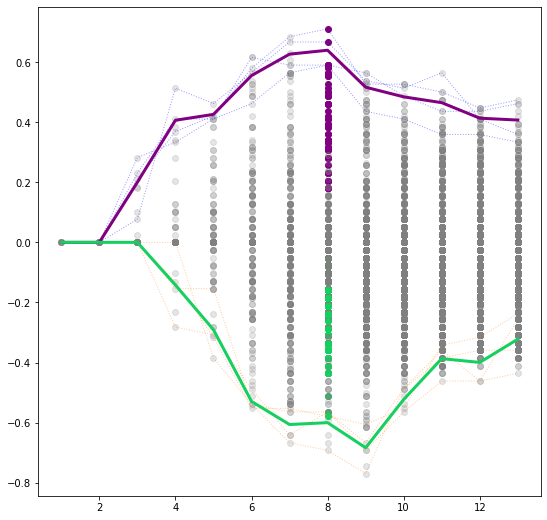

In [11]:
fig = plt.figure(1,figsize=(9,9))
ax1 = fig.add_subplot(111)
anat_avg = np.zeros(13,)
inat_avg = np.zeros(13,)
for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,14,1)
    xticks = []
    x2ticks = []
    anat = []
    inat = []
    for cl in X:
        xticks.append(2**cl)
        x2ticks.append(number_of_neurons//2**cl)
        i = 0
        temp = []
        for item in clf_result[cl].keys():
            if cl == 8:
                if clf_result[cl][item][0] in pi_ana[f]:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='#800080')
                elif clf_result[cl][item][0] in pi_ina[f]:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='#15CF5F')
                else:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            else:
                plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            temp.append(clf_result[cl][item][0])
            i += 1
        anat.append(np.max(temp))
        inat.append(np.min(temp))
     
    anat_avg = np.add(anat_avg,anat)
    inat_avg = np.add(inat_avg,inat)
    plt.plot(X,anat, color='b',linewidth=1, alpha=0.4,linestyle='dotted')
    plt.plot(X,inat, color='C1',linewidth=1,alpha=0.4,linestyle='dotted')

for i in range(13):
    anat_avg[i] = anat_avg[i] / 4.
    inat_avg[i] = inat_avg[i] / 4.
    
plt.plot(X,anat_avg, color='#800080',linewidth=3,label='Animate')
plt.plot(X,inat_avg, color='#15CF5F',linewidth=3, label ='Inanimate')

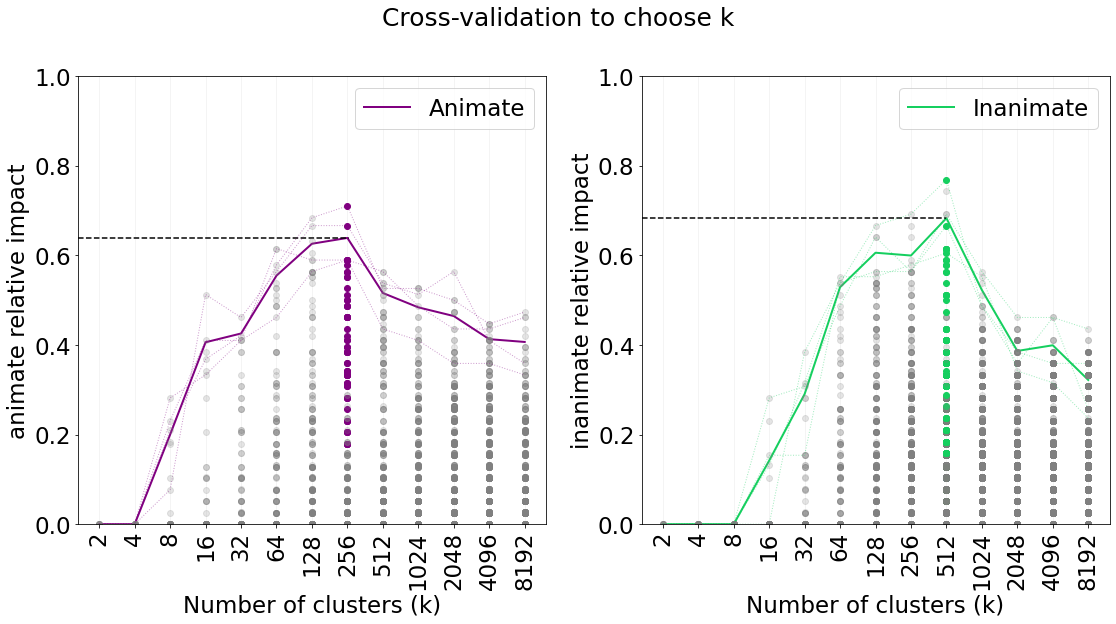

In [12]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23
fig.suptitle('Cross-validation to choose k', fontsize=25)


plt.subplot(1, 2, 1)
plt.plot(range(1,14,1), anat_avg, color='#800080', linewidth=2, label='Animate')
plt.grid(axis='x', color='0.95')
plt.xticks(range(1,14,1),xticks, rotation=90)
plt.axhline(y=max(anat_avg), color='black', linestyle='--', xmin=0, xmax=0.58)
plt.ylim([0,1])
plt.ylabel('animate relative impact')
plt.xlabel('Number of clusters (k)')

for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,14,1)
    anat = []
    for cl in X:
        i = 0
        temp =[]
        for item in clf_result[cl].keys():
            if cl == 8:
                if clf_result[cl][item][0] in pi_ana[f]:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='#800080')
                else:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            else:
                plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            i += 1
            temp.append(clf_result[cl][item][0])
        anat.append(np.max(temp))
    plt.plot(range(1,14,1),anat, color='#800080',linewidth=1, alpha=0.4,linestyle='dotted')
plt.legend()

inat_avg_pos = -1 * inat_avg
plt.subplot(1, 2, 2)
plt.plot(range(1,14,1), inat_avg_pos, color='#15CF5F', linewidth=2, label='Inanimate')
plt.grid(axis='x', color='0.95')
plt.xticks(range(1,14,1),xticks, rotation=90)
plt.axhline(y=max(inat_avg_pos), color='black', linestyle='--', xmin=0, xmax=0.65)
plt.ylabel('inanimate relative impact')
plt.xlabel('Number of clusters (k)')
plt.ylim([0,1])

for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,14,1)
    inat = []
    for cl in X:
        i = 0
        temp =[]
        for item in clf_result[cl].keys():
            if cl == 9:
                if clf_result[cl][item][0] in pi_ina[f]:
                    plt.plot(cl,-1*clf_result[cl][item][0],'go',color='#15CF5F')
                else:
                    plt.plot(cl,-1*clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            else:
                plt.plot(cl,-1*clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            i += 1
            temp.append(-1*clf_result[cl][item][0])
        inat.append(np.max(temp))
    plt.plot(range(1,14,1),inat, color='#15CF5F',linewidth=1, alpha=0.4,linestyle='dotted')
plt.legend()

plt.tight_layout()
#plt.savefig('../../results/mobile_cross_fold.png')

In [ ]:
import gc
from keras import backend as K 
#del model
K.clear_session()
gc.collect()

# Step 1.2 Ablating Intersection units

In [11]:
print(len(loc_ana_avg), len(loc_ina_avg))

21104 10789


In [12]:
intersection_loc_ana_avg =  loc_ana_avg
intersection_loc_ina_avg =  loc_ina_avg
print(len(intersection_loc_ana_avg), len(intersection_loc_ina_avg))

21104 10789


In [9]:
folder = 'pkl_mobile'
model_name = 'MobileNetV2'
debug = False

In [10]:
#%%time
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans

#Testing on test data{
data_path = '../../data/'+folder+'/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=57255, #100x
                             random_state=42,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

#DO CLUSTERING AND GET CLUSTERS


#import genieclust
#import hdbscan
#import smm

j = 512  #Set this value from scree plot!
method = 'GMM'
print(j)

clf = GaussianMixture(n_components=j, covariance_type='full',random_state=42)

512


In [15]:
%time
global debug
debug = False
layer_info = {}
#Comparing Layer lesions
classes = ['animate','inanimate']
folder ='pkl_mobile'
#classes = ['T1A','T1B']
#folder ='pkl_test_1'

label = 'mobile'
layer_info[label] = {}

lambda_mask = np.ones(shape=((5725552,)))
print('no', '0')
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('No Lesion: ',dprime)
layer_info[label]['no'] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#Animate lesion


lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[loc_ana_avg] = 0.
print('ana-loc', len(loc_ana_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Animate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#InAnimate lesion


lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[loc_ina_avg] = 0.
print('ina-loc', len(loc_ina_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Inanimate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 20.7 µs
no 0
Instructions for updating:
Colocations handled automatically by placer.
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
No Lesion:  -0.05128205128205132
ana-loc 21104
animate 0 39 1.0 0.0
inanimate 22 39 0.4358974358974359 0.5641025641025641
Animate lesion:  0.5641025641025641
ina-loc 10789
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 30 39 0.23076923076923073 0.7692307692307693
Inanimate lesion:  -0.07692307692307687


In [16]:
with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold)) 

In [17]:
x = X[:,0]
y = X[:,1]

In [18]:
spax = np.asarray(x[loc_ana_avg])
spay = np.asarray(y[loc_ana_avg])

In [19]:
spix = np.asarray(x[loc_ina_avg])
spiy = np.asarray(y[loc_ina_avg])

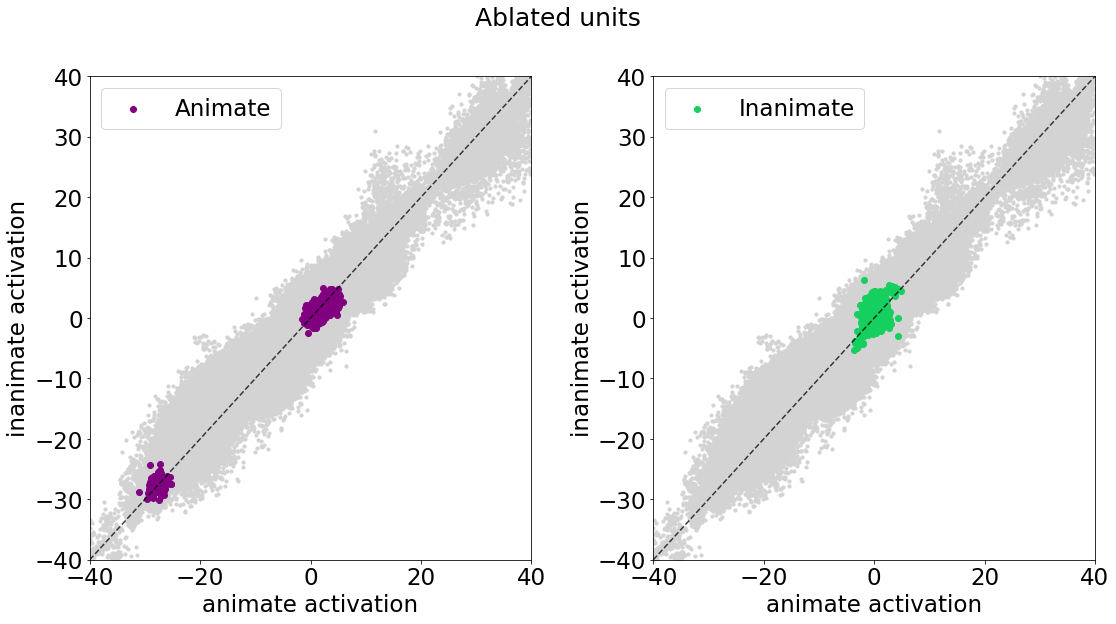

In [22]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23
fig.suptitle('Ablated units', fontsize=25)


plt.subplot(1, 2, 1)
plt.scatter(x,y, c='lightgray', s=10,vmin=-1, vmax=1)
plt.scatter(spax, spay, label='Animate',color='#800080')
plt.plot([-40,40],[-40,40], 'k--', color='black', alpha=0.75)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter( x,y, c='lightgray', s=10,vmin=-1, vmax=1)
plt.scatter(spix, spiy, color='#15CF5F', label='Inanimate')
plt.plot([-40,40],[-40,40], 'k--', color='black', alpha=0.75)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')

plt.legend()

plt.tight_layout()
plt.savefig('../../../mobile_intersection_scatter.png')

# Step 2 - Using the k from Step 1 to do the final groupings

In [56]:
folder = 'pkl_mobile'
model_name = 'MobileNetV2'
debug = False

In [73]:
#%%time
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
#Testing on test data{
data_path = '../../data/'+folder+'/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=57255, #100x
                             random_state=42,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

#DO CLUSTERING AND GET CLUSTERS


#import genieclust
#import hdbscan
#import smm

j = 256  #Set this value from scree plot!
method = 'GMM'
print(j)

clf = GaussianMixture(n_components=j, covariance_type='full',random_state=42)
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
#y_pred = clf.fit_predict(X_new)
print(set(y_pred))
#Z = clf.predict(X)

for label in set(y_pred):
    

    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.
    
    print('Cluster: ',j,'Label: ', label,'Number of units in cluster:', len(loc_new))

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None,\
                        pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)
    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    keras.backend.clear_session()
    gc.collect()
    del model

    result[label] = [dprime, loc_new]

256
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 35 39 0.10256410256410253 0.8974358974358975
Cluster:  256 Label:  46 Number of units in cluster: 3573
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cluster:  256 Label:  47 Number of units in cluster: 4028
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 29 39 0.2564102564102564 0.7435897435897436
Cluster:  256 Label:  48 Number of units in cluster: 2093
animate 27 39 0.3076923076923077 0.6923076923076923
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  256 Label:  49 Number of units in cluster: 3995
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cluster:  256 Label:  50 Number of units in cluster: 6550
animate 27 39 0.3076923076923077 0.6923076923076923
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cluster:  256 Label:  51 Number of units in cluster: 54
animate 35 

Cluster:  256 Label:  97 Number of units in cluster: 11220
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  256 Label:  98 Number of units in cluster: 93099
animate 22 39 0.4358974358974359 0.5641025641025641
inanimate 1 39 0.9743589743589743 0.02564102564102566
Cluster:  256 Label:  99 Number of units in cluster: 931
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  100 Number of units in cluster: 1849
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  101 Number of units in cluster: 1361
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  102 Number of units in cluster: 1699
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 35 39 0.10256410256410253 0.8974358974358975
Cluste

animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  256 Label:  149 Number of units in cluster: 2396
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  150 Number of units in cluster: 862
animate 37 39 0.05128205128205132 0.9487179487179487
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  151 Number of units in cluster: 37605
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 22 39 0.4358974358974359 0.5641025641025641
Cluster:  256 Label:  152 Number of units in cluster: 1920
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  153 Number of units in cluster: 3691
animate 26 39 0.33333333333333337 0.6666666666666666
inanimate 26 39 0.33333333333333337 0.6666666666666666
Cluster:  256 Label:  154 Number of units in cluster: 3122


inanimate 11 39 0.717948717948718 0.28205128205128205
Cluster:  256 Label:  199 Number of units in cluster: 361
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  256 Label:  200 Number of units in cluster: 3978
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  256 Label:  201 Number of units in cluster: 3829
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 35 39 0.10256410256410253 0.8974358974358975
Cluster:  256 Label:  202 Number of units in cluster: 3112
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 29 39 0.2564102564102564 0.7435897435897436
Cluster:  256 Label:  203 Number of units in cluster: 15031
animate 30 39 0.23076923076923073 0.7692307692307693
inanimate 21 39 0.46153846153846156 0.5384615384615384
Cluster:  256 Label:  204 Number of units in cluster: 72
animate 35 39 0.10256410256410253 0.8974358974358975
inani

inanimate 0 39 1.0 0.0
Cluster:  256 Label:  250 Number of units in cluster: 1554
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  256 Label:  251 Number of units in cluster: 2532
animate 29 39 0.2564102564102564 0.7435897435897436
inanimate 26 39 0.33333333333333337 0.6666666666666666
Cluster:  256 Label:  252 Number of units in cluster: 3514
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  253 Number of units in cluster: 712
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  254 Number of units in cluster: 47937
animate 0 39 1.0 0.0
inanimate 28 39 0.28205128205128205 0.717948717948718
Cluster:  256 Label:  255 Number of units in cluster: 461
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205


In [74]:
list(result.values()),X.shape

([[0.05128205128205121,
   [409640,
    415704,
    424188,
    426056,
    428476,
    430956,
    443260,
    471896,
    482188,
    485804,
    486728,
    518268,
    524584,
    525740,
    530172,
    535544,
    542716,
    543112,
    546712,
    553800,
    556204,
    561736,
    573468,
    574956,
    589640,
    594456,
    595132,
    595404,
    595708,
    1277663,
    1283039,
    2262355,
    2274356,
    2301408,
    2316495,
    2317215,
    2910323,
    3535612,
    3539587,
    3779382,
    3779478,
    3780150,
    3782550,
    3785046,
    3803670,
    4139290,
    4906476,
    405128,
    410412,
    411864,
    412412,
    419016,
    430056,
    435548,
    451788,
    487048,
    489708,
    496680,
    502108,
    508376,
    518988,
    528284,
    532028,
    535304,
    559228,
    574972,
    575448,
    591228,
    593356,
    596540,
    599244,
    2257652,
    2311503,
    2319951,
    2326915,
    2894387,
    2901059,
    2924483,
    3540495,
  

In [42]:
x = X[:,0]
y = X[:,1]

In [108]:
print(len(x), len(y))

5725552 5725552


In [77]:
z_temp = []
for item in y_pred:
    z_temp.append(result[item][0])
print(len(z_temp),len(X_new))
loc_z = kmeans.predict(X_new)
z = np.ones(shape=((5725552,)))
for i in range(len(loc_z)):
    temp = np.where(pred_kmeans==loc_z[i])[0]
    z[temp] = z_temp[i]

57255 57255


In [16]:
with open('../../data/'+folder+'/kmeans_first_test_512_cluster'+model_name+'.pkl',"rb") as f:
        result, y_pred_kmeans,z  = pickle.load(f)

In [78]:
with open('../../data/'+folder+'/kmeans_first_test_256_cluster'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([result,y_pred, z], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana_256 = int(list(result.values()).index(max(result.values())))
ina_256 = int(list(result.values()).index(min(result.values())))
print(result[ana_256][0], -1*(result[ina_256][0]))

254 167
0.717948717948718 0.5897435897435898


In [66]:
result[177]

0.717948717948718

In [17]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana_512 = int(list(result.values()).index(max(result.values())))
ina_512 = int(list(result.values()).index(min(result.values())))
print(result[ana_512][0], -1*(result[ina_512][0]))

114 405
0.6666666666666666 0.46153846153846156


In [ ]:
ana = ana_256
ina = ina_512

In [14]:
loc_ana_avg = []
loc_ina_avg = []

In [15]:
loc_ana_avg = result[ana_256][1]
print(len(loc_ana_avg))

47937


In [18]:
loc_ina_avg = result[ina_512][1]
print(len(loc_ina_avg))

22747


In [19]:
test_loc_ana_avg = loc_ana_avg
test_loc_ina_avg = loc_ina_avg
print(len(test_loc_ana_avg),len(test_loc_ina_avg))

47937 22747


In [64]:
spax = []
spay = []
for i in range(0,len(z)):
    if z[i] == result[ana_256]:
        spax.append(x[i])
        spay.append(y[i])
        loc_ana_avg.append(i)

spax = np.asarray(spax)
spay = np.asarray(spay)

In [38]:
spix = []
spiy = []
for i in range(0,len(z)):
    if z[i] == result[ina_512]:
        spix.append(x[i])
        spiy.append(y[i])
        loc_ina_avg.append(i)
spix = np.asarray(spix)
spiy = np.asarray(spiy)

In [49]:
print(len(loc_ana_avg), len(loc_ina_avg))

47937 22747


In [54]:
test_loc_ana_avg = loc_ana_avg
test_loc_ina_avg = loc_ina_avg
print(len(test_loc_ana_avg),len(test_loc_ina_avg))

88352 22747


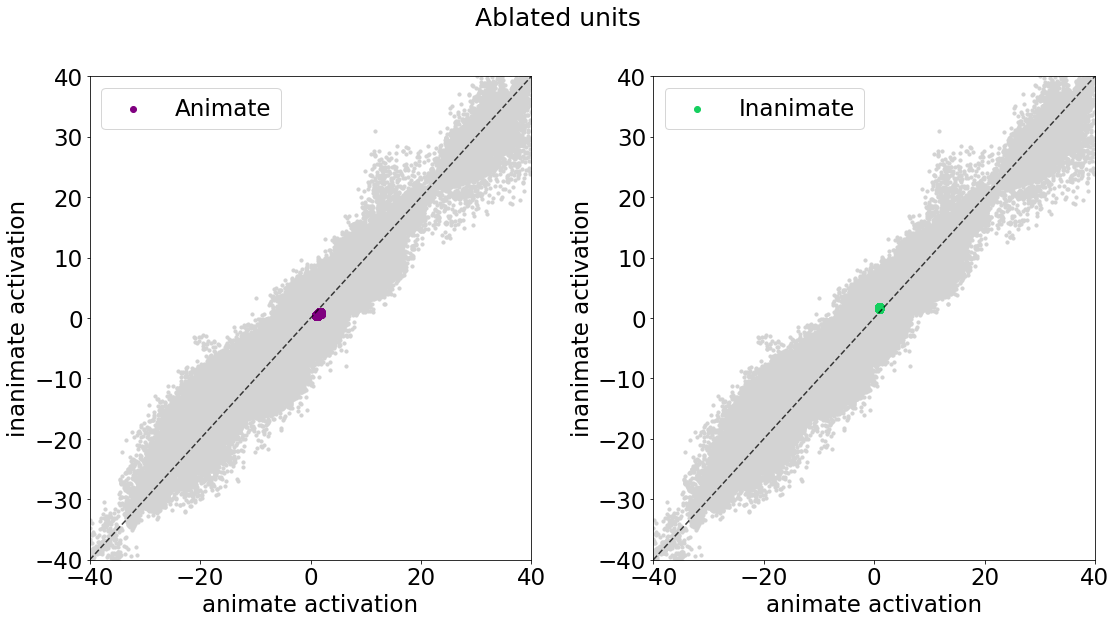

In [55]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23
fig.suptitle('Ablated units', fontsize=25)


plt.subplot(1, 2, 1)
plt.scatter(x,y, c='lightgray', s=10,vmin=-1, vmax=1)
plt.scatter(spax, spay, label='Animate',color='#800080')
plt.plot([-40,40],[-40,40], 'k--', color='black', alpha=0.75)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter( x,y, c='lightgray', s=10,vmin=-1, vmax=1)
plt.scatter(spix, spiy, color='#15CF5F', label='Inanimate')
plt.plot([-40,40],[-40,40], 'k--', color='black', alpha=0.75)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')
plt.legend()

plt.tight_layout()
plt.savefig('../../../mobile_scatter.png')

In [56]:
z, max(z), min(z)

(array([-0.07692308, -0.07692308, -0.07692308, ..., -0.23076923,
         0.12820513, -0.02564103]),
 0.6666666666666666,
 -0.46153846153846156)

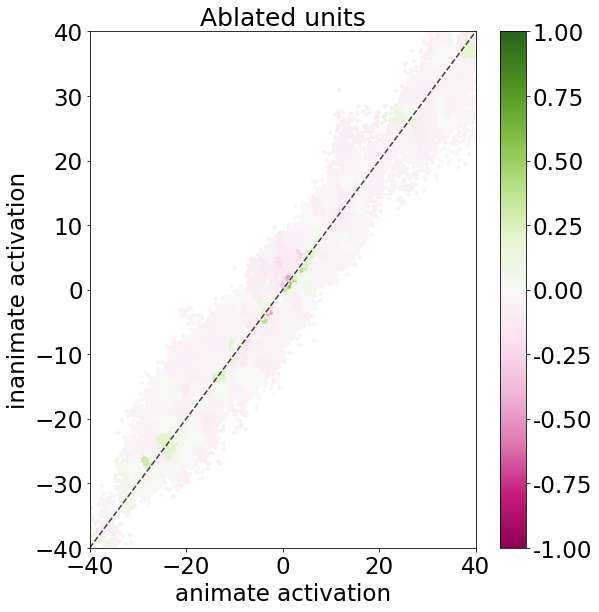

In [57]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23


plt.subplot(1, 2, 1)
sc = plt.scatter(x,y, c=z, s=10,vmin=-1, vmax=1,cmap='PiYG')
#plt.scatter(spax, spay, label='Animate',color='#800080')
plt.plot([-40,40],[-40,40], 'k--', color='black', alpha=0.75)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')


#plt.legend()
plt.colorbar(sc, format='%0.2f')
plt.title('Ablated units', fontsize=25)
plt.tight_layout()
#plt.savefig('../../results/mobile_scatter.png')

In [ ]:
#To check for units that are selectively shared between animate and inanimate category
list(set(np.where(z== result[ana_256])[0]) & set(np.where(z== result[ina_512])[0]))

In [67]:
%time
global debug
debug = False
layer_info = {}
#Comparing Layer lesions
classes = ['animate','inanimate']
folder = label ='pkl_mobile'
#classes = ['T5A','T5B']
#folder = label ='pkl_test_5'

layer_info[label] = {}
#Before lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

# pred = clf.predict(X_new)
# loc = np.where(pred==label)[0]
# loc_new =[]
# for i in range(len(loc)):
#     temp = np.where(pred_kmeans==loc[i])[0]
#     loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
print('no', '0')
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, \
                    pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
    #print(image_list_valid)
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('No Lesion: ',dprime)
layer_info[label]['no'] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#Animate lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)(

# pred = clf.predict(X_new)
# loc = np.where(pred==label)[0]
# loc_new =[]
# for i in range(len(loc)):
#     temp = np.where(pred_kmeans==loc[i])[0]
#     loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[test_loc_ana_avg] = 0.
print('test ana-loc', len(test_loc_ana_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None,\
                    pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Animate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#InAnimate lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

# pred = clf.predict(X_new)
# loc = np.where(pred==label)[0]
# loc_new =[]
# for i in range(len(loc)):
#     temp = np.where(pred_kmeans==loc[i])[0]
#     loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[test_loc_ina_avg] = 0.
print('test ina-loc', len(test_loc_ina_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Inanimate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

'''
#Animate lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)(

# pred = clf.predict(X_new)
# loc = np.where(pred==label)[0]
# loc_new =[]
# for i in range(len(loc)):
#     temp = np.where(pred_kmeans==loc[i])[0]
#     loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[intersection_loc_ana_avg] = 0.
print('intersection ana-loc', len(intersection_loc_ana_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Animate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#InAnimate lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

# pred = clf.predict(X_new)
# loc = np.where(pred==label)[0]
# loc_new =[]
# for i in range(len(loc)):
#     temp = np.where(pred_kmeans==loc[i])[0]
#     loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[intersection_loc_ina_avg] = 0.
print('ina-loc', len(intersection_loc_ina_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Inanimate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model
'''

CPU times: user 20 µs, sys: 3 µs, total: 23 µs
Wall time: 44.3 µs
no 0
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
No Lesion:  -0.05128205128205132
test ana-loc 47937
animate 0 39 1.0 0.0
inanimate 28 39 0.28205128205128205 0.717948717948718
Animate lesion:  0.717948717948718
test ina-loc 22747
animate 28 39 0.28205128205128205 0.717948717948718
inanimate 10 39 0.7435897435897436 0.2564102564102564
Inanimate lesion:  -0.46153846153846156


'\n#Animate lesion\n#print(\'Pre-layer-lesioning\')\n#print(\'Label:\',label)\n#print(\'Layer:\',layer)(\n\n# pred = clf.predict(X_new)\n# loc = np.where(pred==label)[0]\n# loc_new =[]\n# for i in range(len(loc)):\n#     temp = np.where(pred_kmeans==loc[i])[0]\n#     loc_new.extend(temp)\n\nlambda_mask = np.ones(shape=((5725552,)))\nlambda_mask[intersection_loc_ana_avg] = 0.\nprint(\'intersection ana-loc\', len(intersection_loc_ana_avg))\nmodel = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)\n\nflag = 0\ndprime = 0.\nfor p in classes:\n    im_valid_test = []\n    image_list_valid = \'../../data/\'+folder+\'/\'+p+\'_MobileNetV2_image_list_test.txt\'\n    with open(image_list_valid,\'r\') as f:\n        for line in f.readlines():\n            im_valid_test.append(line.strip(\'\n\'))\n    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,25

In [ ]:
import gc
keras.backend.clear_session()
gc.collect()
if 'model' in locals():
    del model

# Step 2.1 - Salience score experiments

In [ ]:
#Activation plot with Salience
lambda_mask = np.ones(shape=((5725552,)))
# print(len(loc_ana_avg),' out of 5725552')
# lambda_mask[loc_ana_avg] = 0.
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)

layer_idx = vis_utils.find_layer_idx(model, 'Logits')
model.layers[layer_idx].activation = keras.activations.linear

analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)

image_list_valid = '../../data/pkl_mobile/animate_MobileNetV2_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))

all_data = []
for image_name in im_valid_test[0:2]:
    x = preprocess_image_batch([image_name],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    a = analyzer.analyze(x)

    data = []# Step 2.1 - Salience score experiments

    for k, v in analyzer._reversed_tensors:
        weights = model.layers[k[0]].get_weights()
        if len(weights) > 0:
            if model.layers[k[0]].name != 'Logits' and not model.layers[k[0]].name.startswith('lambda'):
                temp = np.mean(v, axis=0).ravel()
                data = np.append(data, temp)
    all_data.append(data)
all_data = np.asarray(all_data)

In [ ]:
z_sal = np.mean(all_data, axis=0)
n, bins, patches = plt.hist(z_sal,50, density=True, facecolor='g', alpha=0.75)

plt.ylim([0,1])
#plt.xlim([-0.07,0.07])
plt.title('Distribution of Salience')
plt.grid(True)
plt.show()

In [ ]:
print(max(z_sal),min(z_sal))
#print(sorted(z_sal)[::-1][0:50])

In [ ]:
abs_max = np.amax(np.abs(z_sal))
z_sal_norm = z_sal * (1.0 / abs_max)
n, bins, patches = plt.hist(z_sal_norm,260, density=True, facecolor='g', alpha=0.75)

#plt.ylim([0,1])
plt.xlim([-0.1,0.1])
plt.title('Distribution of Salience - Normalized')
plt.grid(True)
plt.show()

In [ ]:
print(max(z_sal_norm),min(z_sal_norm))

In [ ]:
sal_ana_avg = np.where((z_sal_norm < -0.022) | (z_sal_norm > 0.022))[0]
print(len(sal_ana_avg), len(list(set(sal_ana_avg) & set(loc_ana_avg))), \
     len(list(set(sal_ana_avg) & set(loc_ina_avg))))

In [ ]:
sal_ina_avg = np.where((z_sal_norm < -0.05) | (z_sal_norm > 0.05))[0]
print(len(sal_ina_avg), len(list(set(sal_ina_avg) & set(loc_ana_avg))), \
     len(list(set(sal_ina_avg) & set(loc_ina_avg))))

In [ ]:
lambda_mask = np.ones(shape=((5725552,)))
print(len(sal_ana_avg),' out of 5725552')
lambda_mask[sal_ana_avg] = 0.
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)
    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Salience lesion: ',dprime)  
keras.backend.clear_session()
gc.collect()
del model

'''
Salience Inanimate Lesion

animate 11 39 0.717948717948718 0.28205128205128205
inanimate 17 39 0.5641025641025641 0.4358974358974359
Salience lesion:  0.15384615384615385

Salience Animate Lesion

animate 21 39 0.46153846153846156 0.5384615384615384
inanimate 22 39 0.4358974358974359 0.5641025641025641
Salience lesion:  0.02564102564102566
'''

# Step 2.2 - representation dissimilarity score experiments (RDS)

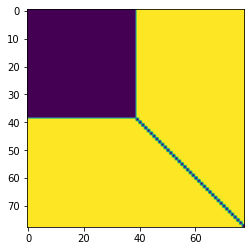

In [10]:
# Create Animate template RDM
animate_template_RDM = np.ones((78,78))
for i in range(39):
    for j in range(39):
        animate_template_RDM[i][j] = 0
for i in range(39,78):
    for j in range(39,78):
        if i == j:
            animate_template_RDM[i][j] = 0
plt.imshow(animate_template_RDM)

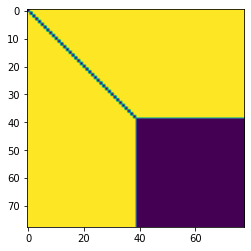

In [11]:
# Create Inanimate template RDM
inanimate_template_RDM = np.ones((78,78))
for i in range(39,78):
    for j in range(39,78):
        inanimate_template_RDM[i][j] = 0
for i in range(39):
    for j in range(39):
        if i == j:
            inanimate_template_RDM[i][j] = 0
plt.imshow(inanimate_template_RDM)

In [ ]:
#Testing data pkl - animate
im_test = []
data_animate_activations = []
image_list_test = '../../data/pkl_mobile/animate_MobileNetV2_image_list_test.txt'
with open(image_list_test,'r') as f:
    for line in f.readlines():
        im_test.append(line.strip('\n'))

im_temp = preprocess_image(im_test,227,227, color_mode="bgr")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

flag =0      
total = 0
for j in range(len(im_test)):
    im_temp = preprocess_image_batch([im_test[j]],227,227, color_mode="bgr")
    out = model.predict(im_temp,batch_size=64)
    
    predicted_valid_wids = []
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[0]))
        
    count, error  = top5accuracy([true_valid_wids[j]], predicted_valid_wids)

    total += count
    #print true_valid_wids[j], predicted_valid_wids[0]


    #}ltauResult(correlation=0.2664768530504399, p
    # Code snippet to get the activation values and saving information{
    data = np.array([])


    i = 0
    result ={}
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            if result.get(layer.name, None) is None:
                result[layer.name] = activations[0]
                if len(activations[0].shape) == 4:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1]*activations[0].shape[2]*activations[0].shape[2])
                else:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1])
                if layer.name != 'Logits':
                    #print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
                    if len(data) == 0:
                        data = temp
                    else:
                        shape = data.shape
                        data = np.append(data, temp)
         
        i += 1
    if flag == 0:
        data_animate_activations = data
        flag = 1
    else:
        data_animate_activations = np.append(data_animate_activations,data, axis =0)

In [ ]:
#Testing data pkl - Inanimate
im_test = []
data_inanimate_activations = []
image_list_test = '../../data/pkl_alex/inanimate_image_list_test.txt'
with open(image_list_test,'rb') as f:
    for line in f.readlines():
        im_test.append(line.strip('\n'))

        
true_valid_wids = []
for i in im_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

flag =0      
total = 0
for j in range(len(im_test)):
    im_temp = preprocess_image([im_test[j]],227,227, color_mode="bgr")
    out = model.predict(im_temp,batch_size=64)
    
    predicted_valid_wids = []
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[0]))
        
    count, error  = top5accuracy([true_valid_wids[j]], predicted_valid_wids)

    total += count
    #print true_valid_wids[j], predicted_valid_wids[0]


    #}
    # Code snippet to get the activation values and saving information{
    data = np.array([])


    i = 0
    result ={}
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            if result.get(layer.name, None) is None:
                result[layer.name] = altauResult(correlation=0.2664768530504399, pctivations[0]
                if len(activations[0].shape) == 4:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1]*activations[0].shape[2]*activations[0].shape[2])
                else:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1])
                if layer.name != 'dense_3':
                    #print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
                    if len(data) == 0:
                        data = temp
                    else:
                        shape = data.shape
                        data = np.append(data, temp)
                        data = data.reshape(shape[0], shape[1] + temp.shape[1])
        i += 1
    if flag == 0:
        data_inanimate_activations = data
        flag = 1
    else:
        data_inanimate_activations = np.append(data_inanimate_activations,data, axis =0)
    
print(data_inanimate_activations.shape, total, len(im_test))

In [ ]:
data_cluster_animate = {}
data_cluster_inanimate = {}
data_cluster = {}


for label in range(len(labels)):
    pred = clf.predict(X_new)
    loc = np.where(pred==label)[0]
    loc_new =[]
    for i in range(len(loc)):
        temp = np.where(pred_kmeans==loc[i])[0]
        loc_new.extend(temp)

    
    index_cluster = loc_new
    
    #Animate
    #data_temp = data_animate_activations.copy()
    #for i in data_temp:
    #    i[loc_new] = 0.
    data_temp = data_animate_activations[:,loc_new]
    correlation_mat= 1 - np.corrcoef(data_temp)
    #data_shape = correlation_mat.shape
    #arr_sorted =  sorted(correlation_mat.ravel())
    #s = pd.Series(correlation_mat.ravel())
    #percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
    #data_temp = np.reshape(percentiles, data_shape)
    data_cluster_animate[label] = correlation_mat
    
    #InAnimate
    #data_temp = data_inanimate_activations.copy()
    #for i in data_temp:
    #    i[loc_new] = 0.
    data_temp = data_inanimate_activations[:,loc_new]
    correlation_mat= 1 - np.corrcoef(data_temp)
    #data_shape = correlation_mat.shape
    #arr_sorted =  sorted(correlation_mat.ravel())
    #s = pd.Series(correlation_mat.ravel())
    #percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
    #data_temp = np.reshape(percentiles, data_shape)
    data_cluster_inanimate[label] = correlation_mat
    
    #Total
    data_temp = np.concatenate((data_animate_activations[:,loc_new],data_inanimate_activations[:,loc_new]))
    correlation_mat= 1 - np.corrcoef(data_temp)
    #data_shape = correlation_mat.shape
    #arr_sorted =  sorted(correlation_mat.ravel())
    #s = pd.Series(correlation_mat.ravel())
    #percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
    #data_temp = np.reshape(percentiles, data_shape)
    data_cluster[label] = correlation_mat

In [ ]:
rdm_impact ={}

for label in range(len(labels)):
    #if labels[label] != 0.:
    t_ana, p_ana = stats.kendalltau(data_full_animate,data_cluster_animate[label])
    t_ina, p_ina = stats.kendalltau(data_full_inanimate,data_cluster_inanimate[label])
    t, p = stats.kendalltau(data_cluster_animate[label], data_cluster_inanimate[label])
    diff = float(t_ana - t_ina)
    rdm_impact[label] = p_ina
    print(label, labels[label], t_ana, t_ina)
    

# Step 3 - Generating Salience figures

In [ ]:
#Pre-trained model - Without lesion
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classifier_activation="softmax", classes=1000)

In [ ]:
#Pre-trained model - With lesion
'''
label=ana
#print(label,result[label])
pred = clf.predict(X_new)
loc = np.where(pred==label)
loc_temp = kmeans.predict(X_new[loc[0]])
loc_new =[]
for entry in set(loc_temp):
    temp = np.where(pred_kmeans==entry)[0]
    loc_new.extend(temp)
'''
lambda_mask = np.ones(shape=((5725552,)))
print(len(loc_ana_avg),' out of 5725552')
lambda_mask[loc_ana_avg] = 0.
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)

In [ ]:
image_list_valid = '../../data/pkl_mobile/animate_MobileNetV2_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))
        
im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_valid_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_valid_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
print(count, error)
c=0
w=0
flag  = 0
for i in range(len(true_valid_wids)):
    flag  = 0
    temp = true_valid_wids[i]
    for j in predicted_valid_wids[i][0:5]:
        if j == temp:
            flag = 1
            break
    if flag == 1:
        c +=1
        print(i,'1 - Correct')
    else:
        w+=1
        print(i,'0 - Wrong')
print(c,w)

In [ ]:
image_name = im_valid_test[9]
_img = load_img(image_name,target_size=(224,224))
plt.imshow(_img)

In [ ]:
layer_idx = vis_utils.find_layer_idx(model, 'Logits')
model.layers[layer_idx].activation = keras.activations.linear

In [ ]:
# Get model
# Strip softmax layer
#model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)

In [ ]:
# Add batch axis and preprocess
image_name = im_valid_test[9]
x = preprocess_image_batch([image_name],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
print(x.shape)
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.axis('off')

In [ ]:
no_specific_impact_idx = 4
no_impact_idx = 5
animate_impact_idx = 1
inanimate_impact_idx = 2

In [ ]:
import matplotlib.gridspec as gridspec

#fig = plt.figure(figsize=(8, 24),constrained_layout=True) #figsize - width,height
fig = plt.figure(figsize=(16, 8),constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=4/72,h_pad=4/72, hspace=0, wspace=0)
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
original_flag = 0
row= column = 0
for high_impact_cluster in [-1,1,2]:
    if high_impact_cluster == -1:
        row = 0
        column = 1 
        #Pre-trained model - Without lesion
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                    classifier_activation="softmax", classes=1000)
    elif high_impact_cluster == 1:
        row = 0
        column = 2
        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_ana_avg] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
    elif high_impact_cluster == 2:
        row = 0
        column = 3
        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_ina_avg] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
    else:
        #Pre-trained model - With lesion
        row =  0
        if high_impact_cluster == 1:
            column = 2
        elif high_impact_cluster == 2:
            column = 3
        elif high_impact_cluster == no_impact_idx:
            column = 2
        elif high_impact_cluster == no_specific_impact_idx:
            column = 3
        elif high_impact_cluster == animate_impact_idx:
            column = 4
        else:
            column = 5
        label=high_impact_cluster
        print(label,result[label])
        pred = clf.predict(X_new)
        loc = np.where(pred==label)
        loc_temp = kmeans.predict(X_new[loc[0]])
        loc_new =[]
        for entry in set(loc_temp):
            temp = np.where(pred_kmeans==entry)[0]
            loc_new.extend(temp)

        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_new] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
        
    layer_idx = vis_utils.find_layer_idx(model, 'Logits')
    model.layers[layer_idx].activation = keras.activations.linear
    
    # Create analyzer
    analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)
    
    for class_label in ['animate','inanimate']:
        image_list_valid = '../../data/pkl_mobile/'+class_label+'_MobileNetV2_image_list_test.txt'
        im_valid_test = []
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))

        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
        print(high_impact_cluster, class_label)
        
        color = []
        line_style = []
        c=0
        w=0
        flag  = 0
        for i in range(len(true_valid_wids)):
            flag  = 0
            temp = true_valid_wids[i]
            for j in predicted_valid_wids[i][0:5]:
                if j == temp:
                    flag = 1
                    break
            if flag == 1:
                c +=1
                color.append('green')
                line_style.append('-.')
                #print(i,'1 - Correct')
            else:
                w+=1
                color.append('red')
                line_style.append('-')
                #print(i,'0 - Wrong')
        #print(c,w)
        
        for image_idx in range(23,24): #2,3 - 6,7 - 7,8
            _img = load_img(im_valid_test[image_idx],target_size=(224,224))
            if original_flag < 2:
                ax = fig.add_subplot(spec[row,0])
                ax.imshow(_img)
                ax.axis('off')
                ax.set_aspect('equal')     
                
            x = preprocess_image_batch([im_valid_test[image_idx]],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            #print(x.shape)
            # Apply analyzer w.r.t. maximum activated output-neuron
            a = analyzer.analyze(x)

            # Aggregate along color channels and normalize to [-1, 1]
            a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
            a /= np.max(np.abs(a))
            # Plot
            #print(row,column)
            ax = fig.add_subplot(spec[row,column])
            ax.imshow(a[0], cmap="seismic", clim=(-1, 1))
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_edgecolor(color[image_idx])
                spine.set_linestyle(line_style[image_idx])
                spine.set_linewidth(4.)
            ax.set_aspect('equal')
            row += 1
            if high_impact_cluster == -1:
                column = 1
            elif high_impact_cluster == 1:
                column = 2
            elif high_impact_cluster == 2:
                column = 3
            elif high_impact_cluster == -1:
                column = 1
            elif high_impact_cluster == no_specific_impact_idx:
                column = 3
            elif high_impact_cluster == animate_impact_idx:
                column = 4
            elif high_impact_cluster == inanimate_impact_idx:
                column = 5
            else:
                column = 1
           
  
        if original_flag < 2:
            original_flag += 1
        '''
        print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
        print(count, error)
        '''
        
        
    keras.backend.clear_session()
    gc.collect()
    del model
#plt.savefig('../../results/row-6.png', format='png')

# Step 4 - Representation analysis

In [9]:
folder = 'pkl_mobile'
model_name = 'MobileNetV2'
debug = False

In [58]:
# Activations for k-Means
#%%time
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
#Testing on test data{
data_path = '../../data/'+folder+'/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=57255, #100x
                             random_state=42,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
# Activations for GMM
j = 512  #Set this value from scree plot!
method = 'GMM'
print(j)

clf = GaussianMixture(n_components=j, covariance_type='full',random_state=42)
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
print(set(y_pred))

512
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

In [ ]:
#MPPI for each unit calculation
mppi_result = {}
for label in list(set(y_pred)):
    
    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.
    
    print('Cluster: ',j,'Label: ', label,'Number of units in cluster:', len(loc_new))
    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet", \
                        input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", \
                        lambda_mask = lambda_mask)
    flag = 0
    dprime = 0.
    ana_PI, ina_PI= 0, 0
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if p == 'animate':
            ana_PI = error
            flag = 1
        else:
            ina_PI = error
    keras.backend.clear_session()
    gc.collect()
    del model
    dprime = ana_PI - ina_PI
    mppi_result[label] = [dprime, ana_PI, ina_PI] 

In [85]:
with open('../../data/'+folder+'/mppi_result_512GMM.pkl', 'wb') as handle:
     pickle.dump([mppi_result], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
with open('../../data/'+folder+'/mppi_result_512GMM.pkl', 'rb') as handle:
     mppi_result = pickle.load(handle)

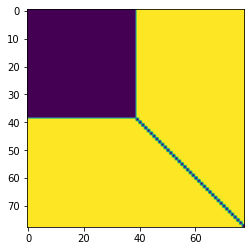

In [13]:
# Create Animate template RDM
animate_template_RDM = np.ones((78,78))
for i in range(39):
    for j in range(39):
        animate_template_RDM[i][j] = 0
for i in range(39,78):
    for j in range(39,78):
        if i == j:
            animate_template_RDM[i][j] = 0
plt.imshow(animate_template_RDM)

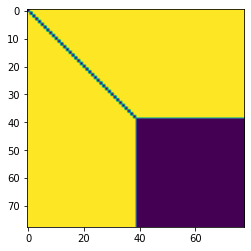

In [14]:
# Create Inanimate template RDM
inanimate_template_RDM = np.ones((78,78))
for i in range(39,78):
    for j in range(39,78):
        inanimate_template_RDM[i][j] = 0
for i in range(39):
    for j in range(39):
        if i == j:
            inanimate_template_RDM[i][j] = 0
plt.imshow(inanimate_template_RDM)

In [ ]:
#RDS for each unit calculation
from scipy import stats

#plt.scatter(X[:,0],X[:,1], c=y_pred) 
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet", \
                    input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax")
dprime = 0.
cluster_activations = {}
cluster_activations['animate'] = np.zeros(shape=(39,5725552))
cluster_activations['inanimate'] = np.zeros(shape=(39,5725552))
for p in classes:

    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))

    #Cluster RDM
    flag =0      
    total = 0

    for j in range(len(im_valid_test)):
        im_temp = preprocess_image_batch([im_valid_test[j]],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        print(p,j,im_valid_test[j])
        data = np.array([])

        i = 0
        for layer in model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:
                activations = get_activations(model,i,im_temp)
                temp = np.mean(activations[0], axis=0).ravel()
                if layer.name != 'Logits':
                    #print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                    data = np.append(data, temp)
            i += 1
        cluster_activations[p][j] = data

print(cluster_activations['animate'].shape)

In [14]:
with open('../../data/'+folder+'/cluster_activations_BAK.pkl', 'wb') as handle:
     pickle.dump([cluster_activations], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [116]:
with open('../../data/'+folder+'/cluster_activations_BAK.pkl', 'rb') as handle:
     cluster_activations = pickle.load(handle)

In [ ]:
#rds for each unit calculation
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet", \
    input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax")
rds_result = {}
for label in list(set(y_pred)):
    
    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
  
    print('Label: ', label, len(loc_new))
    dprime = 0.
    act = np.vstack((cluster_activations[0][classes[0]][:,loc_new],cluster_activations[0][classes[1]][:,loc_new]))
    cluster_RDM = 1 - np.corrcoef(act)    
    
    
    
    ana_RDS, _ = stats.kendalltau(cluster_RDM,animate_template_RDM)
    ina_RDS, _ = stats.kendalltau(cluster_RDM,inanimate_template_RDM)
    dprime = ana_RDS - ina_RDS
    
    rds_result[label] = [dprime, ana_RDS, ina_RDS]

keras.backend.clear_session()
gc.collect()
del model

In [141]:
#rds for each unit calculation
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet", \
    input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax")
comp_result = {}
for label in list(set(y_pred)):
    
    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
  
    print('Label: ', label, len(loc_new))
    dprime = 0.
    act = np.vstack((cluster_activations[0][classes[0]][:,loc_new],cluster_activations[0][classes[1]][:,loc_new]))
    cluster_RDM = 1 - np.corrcoef(act)    
    
    ana_ina_portion = []
    for r in range(39):
        for c in range(39,78):
            #print(r,c)
            ana_ina_portion.append(cluster_RDM[r][c])
    ana_ina_var = np.mean(np.asarray(ana_ina_portion))
    comp_result[label] = [ana_ina_var]

keras.backend.clear_session()
gc.collect()
del model

Label:  0 2773
Label:  1 5265
Label:  2 433
Label:  3 2348
Label:  4 20410
Label:  5 1618
Label:  6 240
Label:  7 516
Label:  8 3046
Label:  9 90260
Label:  10 1225
Label:  11 7996
Label:  12 327
Label:  13 29300
Label:  14 2045
Label:  15 615
Label:  16 3667
Label:  17 5761
Label:  18 1926
Label:  19 681
Label:  20 14581
Label:  21 3689
Label:  22 2159
Label:  23 47795
Label:  24 1860
Label:  25 34598
Label:  26 635
Label:  27 10540
Label:  28 922
Label:  29 47583
Label:  30 72372
Label:  31 2443
Label:  32 2682
Label:  33 994
Label:  34 1189
Label:  35 1518
Label:  36 1039
Label:  37 302
Label:  38 15
Label:  39 4608
Label:  40 207
Label:  41 63863
Label:  42 3325
Label:  43 26382
Label:  44 9596
Label:  45 114
Label:  46 7174
Label:  47 3145
Label:  48 54
Label:  49 943
Label:  50 51
Label:  51 6172
Label:  52 931
Label:  53 402
Label:  54 812
Label:  55 559
Label:  56 3876
Label:  57 18170
Label:  58 27
Label:  59 183
Label:  60 5700
Label:  61 2966
Label:  62 138103
Label:  63 138

Label:  497 1164
Label:  498 1768
Label:  499 77
Label:  500 3279
Label:  501 4310
Label:  502 6289
Label:  503 13022
Label:  504 10544
Label:  505 30654
Label:  506 1541
Label:  507 17268
Label:  508 1108
Label:  509 2831
Label:  510 256
Label:  511 13621


In [142]:
with open('../../data/'+folder+'/comp_result_512GMM.pkl', 'wb') as handle:
     pickle.dump([comp_result], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
with open('../../data/'+folder+'/rds_result_512GMM.pkl', 'wb') as handle:
     pickle.dump([rds_result], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [73]:
#rds variance calculation
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet", \
    input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax")
var_result = {}
for label in list(set(y_pred)):
    
    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
  
    print('Label: ', label, len(loc_new))
    dprime = 0.
    ana_M = 1 - np.corrcoef(cluster_activations[0][classes[0]][:,loc_new])    
    ana_var = np.mean(ana_M[np.triu_indices(len(ana_M), k=1)])
    
    ina_M = 1 - np.corrcoef(cluster_activations[0][classes[1]][:,loc_new])    
    ina_var = np.mean(ina_M[np.triu_indices(len(ina_M), k=1)])
    
    var_result[label] = [ana_var, ina_var, mppi_result[0][label][1],mppi_result[0][label][2]]

keras.backend.clear_session()
gc.collect()
del model

Label:  0 2773
Label:  1 5265
Label:  2 433
Label:  3 2348
Label:  4 20410
Label:  5 1618
Label:  6 240
Label:  7 516
Label:  8 3046
Label:  9 90260
Label:  10 1225
Label:  11 7996
Label:  12 327
Label:  13 29300
Label:  14 2045
Label:  15 615
Label:  16 3667
Label:  17 5761
Label:  18 1926
Label:  19 681
Label:  20 14581
Label:  21 3689
Label:  22 2159
Label:  23 47795
Label:  24 1860
Label:  25 34598
Label:  26 635
Label:  27 10540
Label:  28 922
Label:  29 47583
Label:  30 72372
Label:  31 2443
Label:  32 2682
Label:  33 994
Label:  34 1189
Label:  35 1518
Label:  36 1039
Label:  37 302
Label:  38 15
Label:  39 4608
Label:  40 207
Label:  41 63863
Label:  42 3325
Label:  43 26382
Label:  44 9596
Label:  45 114
Label:  46 7174
Label:  47 3145
Label:  48 54
Label:  49 943
Label:  50 51
Label:  51 6172
Label:  52 931
Label:  53 402
Label:  54 812
Label:  55 559
Label:  56 3876
Label:  57 18170
Label:  58 27
Label:  59 183
Label:  60 5700
Label:  61 2966
Label:  62 138103
Label:  63 138

Label:  497 1164
Label:  498 1768
Label:  499 77
Label:  500 3279
Label:  501 4310
Label:  502 6289
Label:  503 13022
Label:  504 10544
Label:  505 30654
Label:  506 1541
Label:  507 17268
Label:  508 1108
Label:  509 2831
Label:  510 256
Label:  511 13621


In [120]:
ana_M.shape, cluster_activations[0][classes[1]][:,loc_new].shape

((39, 39), (39, 13621))

In [74]:
with open('../../data/'+folder+'/var_result_512GMM.pkl', 'wb') as handle:
     pickle.dump([var_result], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
var_result

{0: [1.0218402581779236,
  1.0231692777724557,
  0.1282051282051282,
  0.15384615384615385],
 1: [1.0236653328432972,
  1.0229496842101153,
  0.10256410256410253,
  0.1282051282051282],
 2: [1.021651675617051,
  1.0242028976686763,
  0.1282051282051282,
  0.15384615384615385],
 3: [1.0058375660099481,
  1.0096103401677992,
  0.6923076923076923,
  0.4871794871794872],
 4: [1.0221796971852928, 1.021650496633502, 1.0, 0.7692307692307692],
 5: [1.0242165102487526,
  1.0190466391387274,
  0.10256410256410253,
  0.15384615384615385],
 6: [1.018979976290473,
  1.0108735853818245,
  0.33333333333333337,
  0.15384615384615385],
 7: [1.0154074779181756,
  1.0201700599358463,
  0.10256410256410253,
  0.15384615384615385],
 8: [1.0036186478390532,
  1.004392617633639,
  0.10256410256410253,
  0.15384615384615385],
 9: [1.0237753839005734,
  1.0233053708678772,
  0.46153846153846156,
  0.28205128205128205],
 10: [1.0104913706430336,
  1.0166055135325123,
  0.3589743589743589,
  0.33333333333333337]

In [ ]:
mppi_result.keys()

In [ ]:
sorted_index = sorted(list(set(pred_kmeans)), key=lambda k: mppi_result[k], reverse=True)
constrained_list = sorted_index[0:int(0.001 * len(mppi_result))]
for item in constrained_list:
    print(mppi_result[item])

In [ ]:
#Calculate the Percent Proportional Performance Impact
animate_percent_result = {}
inanimate_percent_result = {}
#for percent in  [0,0.001,0.003,0.005,0.007,0.009,0.01,0.05,0.1,0.25,0.5,0.75,1.]:
for percent in  [0,0.00001,0.00003, 0.00005,0.00007,0.00009,.0001,0.001,0.005,0.01]:
    sorted_index = sorted(list(set(pred_kmeans)), key=lambda k: mppi_result[k])
    constrained_list = sorted_index[0:int(percent * len(mppi_result))]
    if len(constrained_list):
        loc_temp = kmeans.predict(X_new[constrained_list])
    else:
        loc_temp = []
    loc_new =[]
    for entry in loc_temp:
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
    print('Percent:', percent, 'Units Ablated:', len(loc_new))
    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)
    flag = 0
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))
        if p =='animate':
            animate_percent_result[percent] = float(count) / float(len(im_valid_test))
        elif p =='inanimate':
            inanimate_percent_result[percent] = float(count) / float(len(im_valid_test))
    keras.backend.clear_session()
    gc.collect()
    del model

In [ ]:
#Plotting the performance impact score based on MPPI proportioonal selection
plt.figure(figsize=(9,9))


x_axis = list(animate_percent_result.keys())
y_axis = [animate_percent_result[i] for i in x_axis]

plt.plot(x_axis, y_axis,'o-')

x_axis = list(inanimate_percent_result.keys())
y_axis = [inanimate_percent_result[i] for i in x_axis]

plt.plot(x_axis, y_axis,'xr-')
#plt.xlim([0,1])
plt.ylim([0,1])

In [ ]:
#Plotting the performance impact score based on MPPI proportioonal selection
plt.figure(figsize=(9,9))

x_axis = list(inanimate_percent_result.keys())
y_axis = [inanimate_percent_result[i] for i in x_axis]

plt.plot(x_axis, y_axis)
#plt.xlim([0,1])
plt.ylim([0,1])

In [65]:
folder='pkl_mobile'

In [21]:
font = {'family' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

512 512 1.0 0.07692307692307687 1.020442776503701 0.3664278540124171


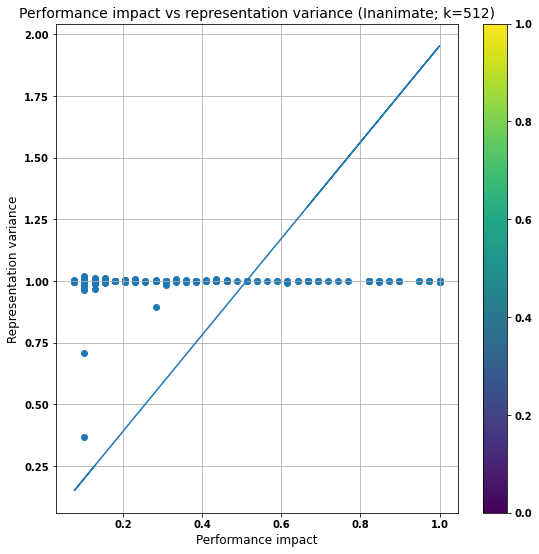

In [145]:
with open('../../data/'+folder+'/mppi_result_512GMM.pkl', 'rb') as handle:
     mppi_result = pickle.load(handle)
        
with open('../../data/'+folder+'/comp_result_512GMM.pkl', 'rb') as handle:
     comp_result = pickle.load(handle)

x = np.array([i[1] for i in list(mppi_result[0].values())])
y = np.array([i[0] for i in list(comp_result[0].values())])
print(len(x), len(y), max(x), min(x), max(y), min(y))


popt, pcov = scipy.optimize.curve_fit(line, x, y)
a = popt

fig, ax = plt.subplots(figsize=(9,9))
hb = plt.scatter(x,y)
#hb =plt.hexbin(x,y,alpha=0.7, bins='log')
ax.ticklabel_format(style='plain')
plt.colorbar(hb)
plt.xlabel('Performance impact', fontsize=12)
plt.ylabel('Representation variance', fontsize=12)
plt.plot(x, line(x, a), label='fit')
plt.title('Performance impact vs representation variance (Inanimate; k=512)', fontsize=14)
plt.grid()
#plt.savefig('../../inanimate_variance_mobilenet_512.png')

57252 57252 -0.07692307692307687 -0.3076923076923077 0.11177269976994378 -0.25285964176694675


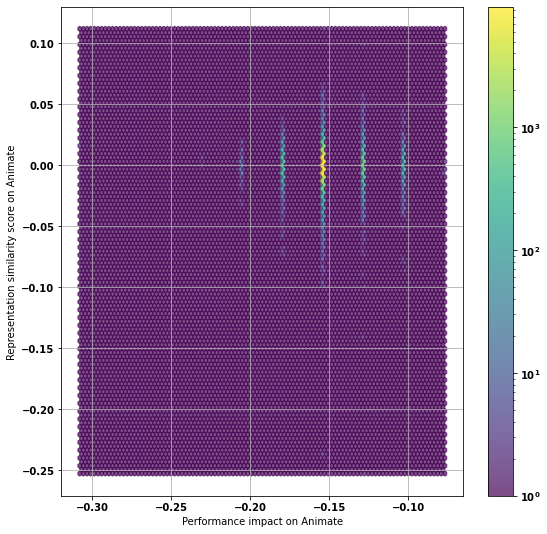

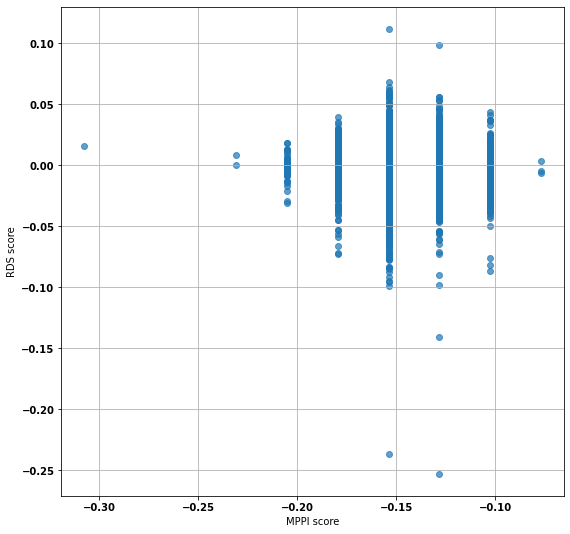

In [128]:
with open('../../data/'+folder+'/mppi_result_50k.pkl', 'rb') as handle:
     mppi_result = pickle.load(handle)

with open('../../data/'+folder+'/rds_result_50k.pkl', 'rb') as handle:
     rds_result = pickle.load(handle)

x = np.array([i[2] for i in list(mppi_result[0].values())])
y = np.array([i[0] for i in list(rds_result[0].values())])
y[np.isnan(y)] = 0
print(len(x), len(y), max(x), min(x), max(y), min(y))



plt.figure(figsize=(9,9))
plt.hexbin(x,y,alpha=0.7, bins='log')
plt.xlabel('Performance impact on Animate')
plt.ylabel('Representation similarity score on Animate')
plt.grid()
plt.colorbar()
#plt.xlim([-0.2,0.2])
#plt.ylim([-0.35,0.2])

plt.figure(figsize=(9,9))
plt.scatter(x,y,alpha=0.7)
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()


In [103]:
import scipy
from matplotlib import pyplot as plt, ticker as mticker
def line(x, a):
    """The line of best fit."""
    # unpack the parameters:
    y = a*x
    return y

popt, pcov = scipy.optimize.curve_fit(line, x, y)

# unpack the parameters of the line of best fit:
a = popt

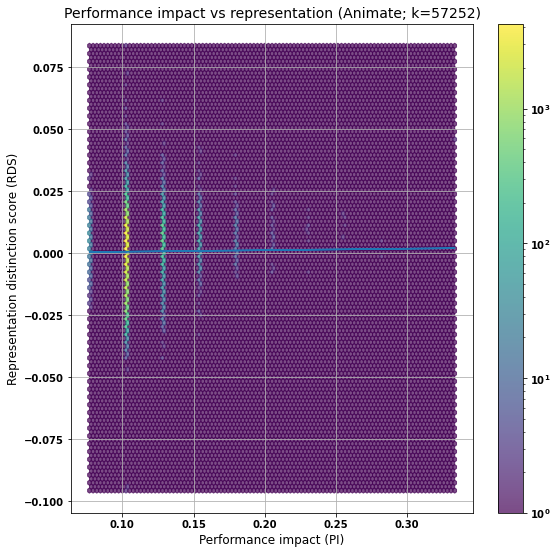

In [104]:
fig, ax = plt.subplots(figsize=(9,9))
hb =plt.hexbin(x,y,alpha=0.7, bins='log')
ax.ticklabel_format(style='plain')
plt.colorbar(hb)
plt.xlabel('Performance impact (PI)', fontsize=12)
plt.ylabel('Representation distinction score (RDS)', fontsize=12)
plt.plot(x, line(x, a), label='fit')
plt.title('Performance impact vs representation (Animate; k=57252)', fontsize=14)
plt.grid()
plt.savefig('../../animate_mobilenet_57252.png')

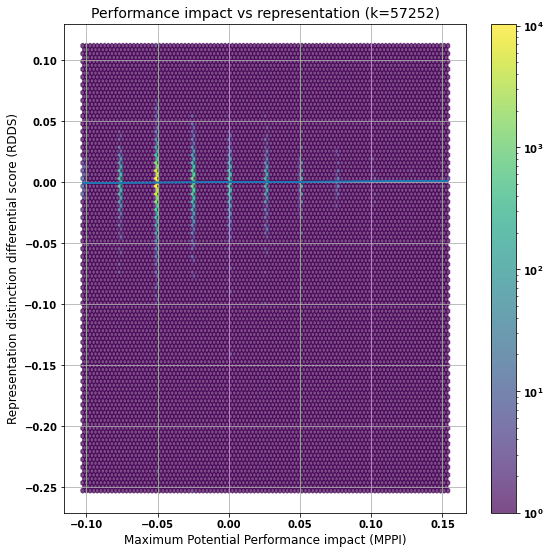

In [98]:
fig, ax = plt.subplots(figsize=(9,9))
hb =plt.hexbin(x,y,alpha=0.7, bins='log')
ax.ticklabel_format(style='plain')
plt.colorbar(hb)
plt.xlabel('Maximum Potential Performance impact (MPPI)', fontsize=12)
plt.ylabel('Representation distinction differential score (RDDS)', fontsize=12)
plt.plot(x, line(x, a), label='fit')
plt.title('Performance impact vs representation (k=57252)', fontsize=14)
plt.grid()
plt.savefig('../../all_mobilenet_50k.png')

In [122]:
import scipy.odr as odr
def odr_line(p, x):
    """The line of best fit."""
    # unpack the parameters:
    y = p*x
    return y

def perform_odr(x, y):
    """Finds the ODR for data {x, y} and returns the result"""
    linear = odr.Model(odr_line)
    mydata = odr.Data(x, y,we=1/np.var(x), wd=1/np.var(y))
    myodr = odr.ODR(mydata, linear, beta0=[0])
    output = myodr.run()
    return output
regression = perform_odr(x, y)

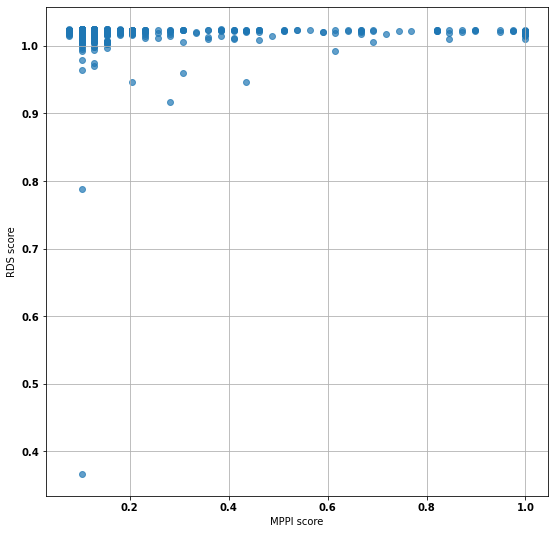

In [133]:
plt.figure(figsize=(9,9))
plt.scatter(x,y,alpha=0.7)
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()
#plt.plot(x, line(x, a), label='fit',color='red')
#plt.plot(x, line(x, regression.beta[0]), label='ODR', lw=3, color='purple')
#plt.legend(title='Legend')

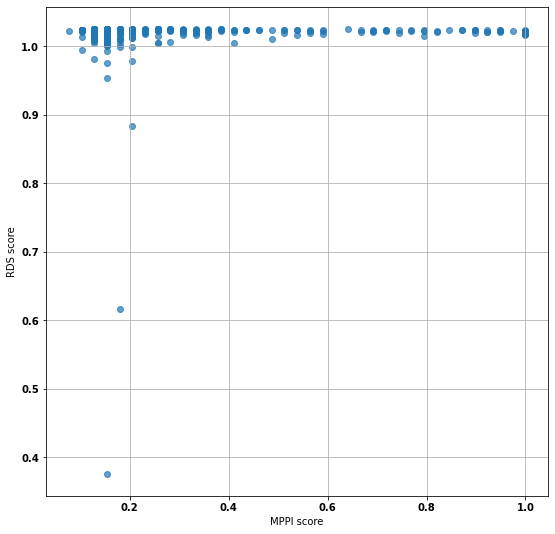

In [131]:
plt.figure(figsize=(9,9))
plt.scatter(x,y,alpha=0.7)
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()
#plt.plot(x, line(x, a), label='fit',color='red')
#plt.plot(x, line(x, regression.beta[0]), label='ODR', lw=3, color='purple')
#plt.legend(title='Legend')

# Grid experiment

In [54]:
import geopandas
import shapely
import pandas as pd
import rtree

In [55]:
len(x), len(y)

(5725552, 5725552)

In [56]:
df = pd.DataFrame({'x':x,'y':y})
gdf = geopandas.GeoDataFrame(df, 
            geometry=geopandas.points_from_xy(df.x, df.y),
            crs="+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs")
gdf.head()

x             y               geometry
0 -5.279969e-02 -2.326558e-03  POINT (-0.053 -0.002)
1 -1.712674e-01  3.853773e-02   POINT (-0.171 0.039)
2 -7.694759e-03  2.928683e-02   POINT (-0.008 0.029)
3  3.598380e-19 -8.087605e-20   POINT (0.000 -0.000)
4 -1.432909e-01  2.641999e-02   POINT (-0.143 0.026)

In [57]:
# total area for the grid
xmin, ymin, xmax, ymax= min(x), min(y), max(x), max(y)
# how many cells across and down
n_cells=128
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )
cell = geopandas.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

In [58]:
cell

geometry
0      POLYGON ((-116.838 -112.160, -116.838 -110.346...
1      POLYGON ((-116.838 -110.346, -116.838 -108.532...
2      POLYGON ((-116.838 -108.532, -116.838 -106.718...
3      POLYGON ((-116.838 -106.718, -116.838 -104.904...
4      POLYGON ((-116.838 -104.904, -116.838 -103.090...
...                                                  ...
16894  POLYGON ((115.361 116.411, 115.361 118.226, 11...
16895  POLYGON ((115.361 118.226, 115.361 120.040, 11...
16896  POLYGON ((115.361 120.040, 115.361 121.854, 11...
16897  POLYGON ((115.361 121.854, 115.361 123.668, 11...
16898  POLYGON ((115.361 123.668, 115.361 125.482, 11...

[16899 rows x 1 columns]

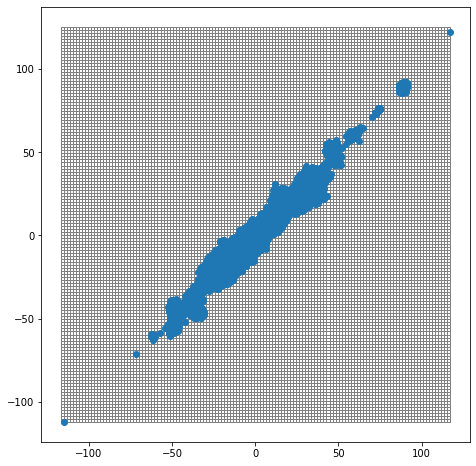

In [59]:
cell.plot(facecolor="none", edgecolor='grey', figsize=(12, 8))
plt.scatter(x,y)

In [18]:
merged = geopandas.sjoin(gdf, cell, how='left', op='within')

In [60]:
r_tree = gdf.sindex

In [68]:
#Cell lesion
cell_mppi = {}
for bbx in range(len(cell)):
    print('Cell:', bbx)

    loc_new = r_tree.query(cell['geometry'][bbx])
    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.
    print('Number of units:', len(loc_new))
    if len(loc_new) == 0.:
        cell_mppi[bbx] = [0,0,0]
        continue
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None,\
                        pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

    flag = 0
    dprime = 0.
    ana_PI = ina_PI = 0
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if p == 'animate':
            ana_PI = error 
            flag = 1
        else:
            ina_PI = error
    dprime = ana_PI - ina_PI
    cell_mppi[bbx] = [dprime, ana_PI, ina_PI]
    keras.backend.clear_session()
    gc.collect()
    del model

Cell: 0
Number of units: 1
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 1
Number of units: 0
Cell: 2
Number of units: 0
Cell: 3
Number of units: 0
Cell: 4
Number of units: 0
Cell: 5
Number of units: 0
Cell: 6
Number of units: 0
Cell: 7
Number of units: 0
Cell: 8
Number of units: 0
Cell: 9
Number of units: 0
Cell: 10
Number of units: 0
Cell: 11
Number of units: 0
Cell: 12
Number of units: 0
Cell: 13
Number of units: 0
Cell: 14
Number of units: 0
Cell: 15
Number of units: 0
Cell: 16
Number of units: 0
Cell: 17
Number of units: 0
Cell: 18
Number of units: 0
Cell: 19
Number of units: 0
Cell: 20
Number of units: 0
Cell: 21
Number of units: 0
Cell: 22
Number of units: 0
Cell: 23
Number of units: 0
Cell: 24
Number of units: 0
Cell: 25
Number of units: 0
Cell: 26
Number of units: 0
Cell: 27
Number of units: 0
Cell: 28
Number of units: 0
Cell: 29
Number of units: 0
Cell: 30
Number of units: 0
Cell: 31
Number of units: 0
Cell: 

Number of units: 0
Cell: 283
Number of units: 0
Cell: 284
Number of units: 0
Cell: 285
Number of units: 0
Cell: 286
Number of units: 0
Cell: 287
Number of units: 0
Cell: 288
Number of units: 0
Cell: 289
Number of units: 0
Cell: 290
Number of units: 0
Cell: 291
Number of units: 0
Cell: 292
Number of units: 0
Cell: 293
Number of units: 0
Cell: 294
Number of units: 0
Cell: 295
Number of units: 0
Cell: 296
Number of units: 0
Cell: 297
Number of units: 0
Cell: 298
Number of units: 0
Cell: 299
Number of units: 0
Cell: 300
Number of units: 0
Cell: 301
Number of units: 0
Cell: 302
Number of units: 0
Cell: 303
Number of units: 0
Cell: 304
Number of units: 0
Cell: 305
Number of units: 0
Cell: 306
Number of units: 0
Cell: 307
Number of units: 0
Cell: 308
Number of units: 0
Cell: 309
Number of units: 0
Cell: 310
Number of units: 0
Cell: 311
Number of units: 0
Cell: 312
Number of units: 0
Cell: 313
Number of units: 0
Cell: 314
Number of units: 0
Cell: 315
Number of units: 0
Cell: 316
Number of unit

Number of units: 0
Cell: 583
Number of units: 0
Cell: 584
Number of units: 0
Cell: 585
Number of units: 0
Cell: 586
Number of units: 0
Cell: 587
Number of units: 0
Cell: 588
Number of units: 0
Cell: 589
Number of units: 0
Cell: 590
Number of units: 0
Cell: 591
Number of units: 0
Cell: 592
Number of units: 0
Cell: 593
Number of units: 0
Cell: 594
Number of units: 0
Cell: 595
Number of units: 0
Cell: 596
Number of units: 0
Cell: 597
Number of units: 0
Cell: 598
Number of units: 0
Cell: 599
Number of units: 0
Cell: 600
Number of units: 0
Cell: 601
Number of units: 0
Cell: 602
Number of units: 0
Cell: 603
Number of units: 0
Cell: 604
Number of units: 0
Cell: 605
Number of units: 0
Cell: 606
Number of units: 0
Cell: 607
Number of units: 0
Cell: 608
Number of units: 0
Cell: 609
Number of units: 0
Cell: 610
Number of units: 0
Cell: 611
Number of units: 0
Cell: 612
Number of units: 0
Cell: 613
Number of units: 0
Cell: 614
Number of units: 0
Cell: 615
Number of units: 0
Cell: 616
Number of unit

Number of units: 0
Cell: 882
Number of units: 0
Cell: 883
Number of units: 0
Cell: 884
Number of units: 0
Cell: 885
Number of units: 0
Cell: 886
Number of units: 0
Cell: 887
Number of units: 0
Cell: 888
Number of units: 0
Cell: 889
Number of units: 0
Cell: 890
Number of units: 0
Cell: 891
Number of units: 0
Cell: 892
Number of units: 0
Cell: 893
Number of units: 0
Cell: 894
Number of units: 0
Cell: 895
Number of units: 0
Cell: 896
Number of units: 0
Cell: 897
Number of units: 0
Cell: 898
Number of units: 0
Cell: 899
Number of units: 0
Cell: 900
Number of units: 0
Cell: 901
Number of units: 0
Cell: 902
Number of units: 0
Cell: 903
Number of units: 0
Cell: 904
Number of units: 0
Cell: 905
Number of units: 0
Cell: 906
Number of units: 0
Cell: 907
Number of units: 0
Cell: 908
Number of units: 0
Cell: 909
Number of units: 0
Cell: 910
Number of units: 0
Cell: 911
Number of units: 0
Cell: 912
Number of units: 0
Cell: 913
Number of units: 0
Cell: 914
Number of units: 0
Cell: 915
Number of unit

Number of units: 0
Cell: 1177
Number of units: 0
Cell: 1178
Number of units: 0
Cell: 1179
Number of units: 0
Cell: 1180
Number of units: 0
Cell: 1181
Number of units: 0
Cell: 1182
Number of units: 0
Cell: 1183
Number of units: 0
Cell: 1184
Number of units: 0
Cell: 1185
Number of units: 0
Cell: 1186
Number of units: 0
Cell: 1187
Number of units: 0
Cell: 1188
Number of units: 0
Cell: 1189
Number of units: 0
Cell: 1190
Number of units: 0
Cell: 1191
Number of units: 0
Cell: 1192
Number of units: 0
Cell: 1193
Number of units: 0
Cell: 1194
Number of units: 0
Cell: 1195
Number of units: 0
Cell: 1196
Number of units: 0
Cell: 1197
Number of units: 0
Cell: 1198
Number of units: 0
Cell: 1199
Number of units: 0
Cell: 1200
Number of units: 0
Cell: 1201
Number of units: 0
Cell: 1202
Number of units: 0
Cell: 1203
Number of units: 0
Cell: 1204
Number of units: 0
Cell: 1205
Number of units: 0
Cell: 1206
Number of units: 0
Cell: 1207
Number of units: 0
Cell: 1208
Number of units: 0
Cell: 1209
Number of 

Cell: 1454
Number of units: 0
Cell: 1455
Number of units: 0
Cell: 1456
Number of units: 0
Cell: 1457
Number of units: 0
Cell: 1458
Number of units: 0
Cell: 1459
Number of units: 0
Cell: 1460
Number of units: 0
Cell: 1461
Number of units: 0
Cell: 1462
Number of units: 0
Cell: 1463
Number of units: 0
Cell: 1464
Number of units: 0
Cell: 1465
Number of units: 0
Cell: 1466
Number of units: 0
Cell: 1467
Number of units: 0
Cell: 1468
Number of units: 0
Cell: 1469
Number of units: 0
Cell: 1470
Number of units: 0
Cell: 1471
Number of units: 0
Cell: 1472
Number of units: 0
Cell: 1473
Number of units: 0
Cell: 1474
Number of units: 0
Cell: 1475
Number of units: 0
Cell: 1476
Number of units: 0
Cell: 1477
Number of units: 0
Cell: 1478
Number of units: 0
Cell: 1479
Number of units: 0
Cell: 1480
Number of units: 0
Cell: 1481
Number of units: 0
Cell: 1482
Number of units: 0
Cell: 1483
Number of units: 0
Cell: 1484
Number of units: 0
Cell: 1485
Number of units: 0
Cell: 1486
Number of units: 0
Cell: 1487

Number of units: 0
Cell: 1744
Number of units: 0
Cell: 1745
Number of units: 0
Cell: 1746
Number of units: 0
Cell: 1747
Number of units: 0
Cell: 1748
Number of units: 0
Cell: 1749
Number of units: 0
Cell: 1750
Number of units: 0
Cell: 1751
Number of units: 0
Cell: 1752
Number of units: 0
Cell: 1753
Number of units: 0
Cell: 1754
Number of units: 0
Cell: 1755
Number of units: 0
Cell: 1756
Number of units: 0
Cell: 1757
Number of units: 0
Cell: 1758
Number of units: 0
Cell: 1759
Number of units: 0
Cell: 1760
Number of units: 0
Cell: 1761
Number of units: 0
Cell: 1762
Number of units: 0
Cell: 1763
Number of units: 0
Cell: 1764
Number of units: 0
Cell: 1765
Number of units: 0
Cell: 1766
Number of units: 0
Cell: 1767
Number of units: 0
Cell: 1768
Number of units: 0
Cell: 1769
Number of units: 0
Cell: 1770
Number of units: 0
Cell: 1771
Number of units: 0
Cell: 1772
Number of units: 0
Cell: 1773
Number of units: 0
Cell: 1774
Number of units: 0
Cell: 1775
Number of units: 0
Cell: 1776
Number of 

Number of units: 0
Cell: 2039
Number of units: 0
Cell: 2040
Number of units: 0
Cell: 2041
Number of units: 0
Cell: 2042
Number of units: 0
Cell: 2043
Number of units: 0
Cell: 2044
Number of units: 0
Cell: 2045
Number of units: 0
Cell: 2046
Number of units: 0
Cell: 2047
Number of units: 0
Cell: 2048
Number of units: 0
Cell: 2049
Number of units: 0
Cell: 2050
Number of units: 0
Cell: 2051
Number of units: 0
Cell: 2052
Number of units: 0
Cell: 2053
Number of units: 0
Cell: 2054
Number of units: 0
Cell: 2055
Number of units: 0
Cell: 2056
Number of units: 0
Cell: 2057
Number of units: 0
Cell: 2058
Number of units: 0
Cell: 2059
Number of units: 0
Cell: 2060
Number of units: 0
Cell: 2061
Number of units: 0
Cell: 2062
Number of units: 0
Cell: 2063
Number of units: 0
Cell: 2064
Number of units: 0
Cell: 2065
Number of units: 0
Cell: 2066
Number of units: 0
Cell: 2067
Number of units: 0
Cell: 2068
Number of units: 0
Cell: 2069
Number of units: 0
Cell: 2070
Number of units: 0
Cell: 2071
Number of 

Number of units: 0
Cell: 2323
Number of units: 0
Cell: 2324
Number of units: 0
Cell: 2325
Number of units: 0
Cell: 2326
Number of units: 0
Cell: 2327
Number of units: 0
Cell: 2328
Number of units: 0
Cell: 2329
Number of units: 0
Cell: 2330
Number of units: 0
Cell: 2331
Number of units: 0
Cell: 2332
Number of units: 0
Cell: 2333
Number of units: 0
Cell: 2334
Number of units: 0
Cell: 2335
Number of units: 0
Cell: 2336
Number of units: 0
Cell: 2337
Number of units: 0
Cell: 2338
Number of units: 0
Cell: 2339
Number of units: 0
Cell: 2340
Number of units: 0
Cell: 2341
Number of units: 0
Cell: 2342
Number of units: 0
Cell: 2343
Number of units: 0
Cell: 2344
Number of units: 0
Cell: 2345
Number of units: 0
Cell: 2346
Number of units: 0
Cell: 2347
Number of units: 0
Cell: 2348
Number of units: 0
Cell: 2349
Number of units: 0
Cell: 2350
Number of units: 0
Cell: 2351
Number of units: 0
Cell: 2352
Number of units: 0
Cell: 2353
Number of units: 0
Cell: 2354
Number of units: 0
Cell: 2355
Number of 

Number of units: 0
Cell: 2606
Number of units: 0
Cell: 2607
Number of units: 0
Cell: 2608
Number of units: 0
Cell: 2609
Number of units: 0
Cell: 2610
Number of units: 0
Cell: 2611
Number of units: 0
Cell: 2612
Number of units: 0
Cell: 2613
Number of units: 0
Cell: 2614
Number of units: 0
Cell: 2615
Number of units: 0
Cell: 2616
Number of units: 0
Cell: 2617
Number of units: 0
Cell: 2618
Number of units: 0
Cell: 2619
Number of units: 0
Cell: 2620
Number of units: 0
Cell: 2621
Number of units: 0
Cell: 2622
Number of units: 0
Cell: 2623
Number of units: 0
Cell: 2624
Number of units: 0
Cell: 2625
Number of units: 0
Cell: 2626
Number of units: 0
Cell: 2627
Number of units: 0
Cell: 2628
Number of units: 0
Cell: 2629
Number of units: 0
Cell: 2630
Number of units: 0
Cell: 2631
Number of units: 0
Cell: 2632
Number of units: 0
Cell: 2633
Number of units: 0
Cell: 2634
Number of units: 0
Cell: 2635
Number of units: 0
Cell: 2636
Number of units: 0
Cell: 2637
Number of units: 0
Cell: 2638
Number of 

Number of units: 0
Cell: 2899
Number of units: 0
Cell: 2900
Number of units: 0
Cell: 2901
Number of units: 0
Cell: 2902
Number of units: 0
Cell: 2903
Number of units: 0
Cell: 2904
Number of units: 0
Cell: 2905
Number of units: 0
Cell: 2906
Number of units: 0
Cell: 2907
Number of units: 0
Cell: 2908
Number of units: 0
Cell: 2909
Number of units: 0
Cell: 2910
Number of units: 0
Cell: 2911
Number of units: 0
Cell: 2912
Number of units: 0
Cell: 2913
Number of units: 0
Cell: 2914
Number of units: 0
Cell: 2915
Number of units: 0
Cell: 2916
Number of units: 0
Cell: 2917
Number of units: 0
Cell: 2918
Number of units: 0
Cell: 2919
Number of units: 0
Cell: 2920
Number of units: 0
Cell: 2921
Number of units: 0
Cell: 2922
Number of units: 0
Cell: 2923
Number of units: 0
Cell: 2924
Number of units: 0
Cell: 2925
Number of units: 0
Cell: 2926
Number of units: 0
Cell: 2927
Number of units: 0
Cell: 2928
Number of units: 0
Cell: 2929
Number of units: 0
Cell: 2930
Number of units: 0
Cell: 2931
Number of 

Number of units: 0
Cell: 3187
Number of units: 0
Cell: 3188
Number of units: 0
Cell: 3189
Number of units: 0
Cell: 3190
Number of units: 0
Cell: 3191
Number of units: 0
Cell: 3192
Number of units: 0
Cell: 3193
Number of units: 0
Cell: 3194
Number of units: 0
Cell: 3195
Number of units: 0
Cell: 3196
Number of units: 0
Cell: 3197
Number of units: 0
Cell: 3198
Number of units: 0
Cell: 3199
Number of units: 0
Cell: 3200
Number of units: 0
Cell: 3201
Number of units: 0
Cell: 3202
Number of units: 0
Cell: 3203
Number of units: 0
Cell: 3204
Number of units: 0
Cell: 3205
Number of units: 0
Cell: 3206
Number of units: 0
Cell: 3207
Number of units: 0
Cell: 3208
Number of units: 0
Cell: 3209
Number of units: 0
Cell: 3210
Number of units: 0
Cell: 3211
Number of units: 0
Cell: 3212
Number of units: 0
Cell: 3213
Number of units: 0
Cell: 3214
Number of units: 0
Cell: 3215
Number of units: 0
Cell: 3216
Number of units: 0
Cell: 3217
Number of units: 0
Cell: 3218
Number of units: 0
Cell: 3219
Number of 

Number of units: 0
Cell: 3473
Number of units: 0
Cell: 3474
Number of units: 0
Cell: 3475
Number of units: 0
Cell: 3476
Number of units: 0
Cell: 3477
Number of units: 0
Cell: 3478
Number of units: 0
Cell: 3479
Number of units: 0
Cell: 3480
Number of units: 0
Cell: 3481
Number of units: 0
Cell: 3482
Number of units: 0
Cell: 3483
Number of units: 0
Cell: 3484
Number of units: 0
Cell: 3485
Number of units: 0
Cell: 3486
Number of units: 0
Cell: 3487
Number of units: 0
Cell: 3488
Number of units: 0
Cell: 3489
Number of units: 0
Cell: 3490
Number of units: 0
Cell: 3491
Number of units: 0
Cell: 3492
Number of units: 0
Cell: 3493
Number of units: 0
Cell: 3494
Number of units: 0
Cell: 3495
Number of units: 0
Cell: 3496
Number of units: 0
Cell: 3497
Number of units: 0
Cell: 3498
Number of units: 0
Cell: 3499
Number of units: 0
Cell: 3500
Number of units: 0
Cell: 3501
Number of units: 0
Cell: 3502
Number of units: 0
Cell: 3503
Number of units: 0
Cell: 3504
Number of units: 0
Cell: 3505
Number of 

Number of units: 0
Cell: 3756
Number of units: 0
Cell: 3757
Number of units: 0
Cell: 3758
Number of units: 0
Cell: 3759
Number of units: 0
Cell: 3760
Number of units: 0
Cell: 3761
Number of units: 0
Cell: 3762
Number of units: 0
Cell: 3763
Number of units: 0
Cell: 3764
Number of units: 0
Cell: 3765
Number of units: 0
Cell: 3766
Number of units: 0
Cell: 3767
Number of units: 0
Cell: 3768
Number of units: 0
Cell: 3769
Number of units: 0
Cell: 3770
Number of units: 0
Cell: 3771
Number of units: 0
Cell: 3772
Number of units: 0
Cell: 3773
Number of units: 0
Cell: 3774
Number of units: 0
Cell: 3775
Number of units: 0
Cell: 3776
Number of units: 0
Cell: 3777
Number of units: 0
Cell: 3778
Number of units: 0
Cell: 3779
Number of units: 0
Cell: 3780
Number of units: 0
Cell: 3781
Number of units: 0
Cell: 3782
Number of units: 0
Cell: 3783
Number of units: 0
Cell: 3784
Number of units: 0
Cell: 3785
Number of units: 0
Cell: 3786
Number of units: 0
Cell: 3787
Number of units: 0
Cell: 3788
Number of 

Number of units: 0
Cell: 4033
Number of units: 0
Cell: 4034
Number of units: 0
Cell: 4035
Number of units: 0
Cell: 4036
Number of units: 0
Cell: 4037
Number of units: 0
Cell: 4038
Number of units: 0
Cell: 4039
Number of units: 0
Cell: 4040
Number of units: 0
Cell: 4041
Number of units: 0
Cell: 4042
Number of units: 0
Cell: 4043
Number of units: 0
Cell: 4044
Number of units: 0
Cell: 4045
Number of units: 0
Cell: 4046
Number of units: 0
Cell: 4047
Number of units: 0
Cell: 4048
Number of units: 0
Cell: 4049
Number of units: 0
Cell: 4050
Number of units: 0
Cell: 4051
Number of units: 0
Cell: 4052
Number of units: 0
Cell: 4053
Number of units: 0
Cell: 4054
Number of units: 0
Cell: 4055
Number of units: 0
Cell: 4056
Number of units: 0
Cell: 4057
Number of units: 0
Cell: 4058
Number of units: 0
Cell: 4059
Number of units: 0
Cell: 4060
Number of units: 0
Cell: 4061
Number of units: 0
Cell: 4062
Number of units: 0
Cell: 4063
Number of units: 0
Cell: 4064
Number of units: 0
Cell: 4065
Number of 

Number of units: 0
Cell: 4320
Number of units: 0
Cell: 4321
Number of units: 0
Cell: 4322
Number of units: 0
Cell: 4323
Number of units: 0
Cell: 4324
Number of units: 0
Cell: 4325
Number of units: 0
Cell: 4326
Number of units: 0
Cell: 4327
Number of units: 0
Cell: 4328
Number of units: 0
Cell: 4329
Number of units: 0
Cell: 4330
Number of units: 0
Cell: 4331
Number of units: 0
Cell: 4332
Number of units: 0
Cell: 4333
Number of units: 0
Cell: 4334
Number of units: 0
Cell: 4335
Number of units: 0
Cell: 4336
Number of units: 0
Cell: 4337
Number of units: 0
Cell: 4338
Number of units: 0
Cell: 4339
Number of units: 0
Cell: 4340
Number of units: 0
Cell: 4341
Number of units: 0
Cell: 4342
Number of units: 0
Cell: 4343
Number of units: 0
Cell: 4344
Number of units: 0
Cell: 4345
Number of units: 0
Cell: 4346
Number of units: 0
Cell: 4347
Number of units: 0
Cell: 4348
Number of units: 0
Cell: 4349
Number of units: 0
Cell: 4350
Number of units: 0
Cell: 4351
Number of units: 0
Cell: 4352
Number of 

Number of units: 0
Cell: 4599
Number of units: 0
Cell: 4600
Number of units: 0
Cell: 4601
Number of units: 0
Cell: 4602
Number of units: 0
Cell: 4603
Number of units: 0
Cell: 4604
Number of units: 0
Cell: 4605
Number of units: 0
Cell: 4606
Number of units: 0
Cell: 4607
Number of units: 0
Cell: 4608
Number of units: 0
Cell: 4609
Number of units: 0
Cell: 4610
Number of units: 0
Cell: 4611
Number of units: 0
Cell: 4612
Number of units: 0
Cell: 4613
Number of units: 0
Cell: 4614
Number of units: 3
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 4615
Number of units: 2
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 4616
Number of units: 1
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 4617
Number of units: 1
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.1538461538461538

Number of units: 0
Cell: 4801
Number of units: 0
Cell: 4802
Number of units: 0
Cell: 4803
Number of units: 0
Cell: 4804
Number of units: 0
Cell: 4805
Number of units: 0
Cell: 4806
Number of units: 0
Cell: 4807
Number of units: 0
Cell: 4808
Number of units: 0
Cell: 4809
Number of units: 0
Cell: 4810
Number of units: 0
Cell: 4811
Number of units: 0
Cell: 4812
Number of units: 0
Cell: 4813
Number of units: 0
Cell: 4814
Number of units: 0
Cell: 4815
Number of units: 0
Cell: 4816
Number of units: 0
Cell: 4817
Number of units: 0
Cell: 4818
Number of units: 0
Cell: 4819
Number of units: 0
Cell: 4820
Number of units: 0
Cell: 4821
Number of units: 0
Cell: 4822
Number of units: 0
Cell: 4823
Number of units: 0
Cell: 4824
Number of units: 0
Cell: 4825
Number of units: 0
Cell: 4826
Number of units: 0
Cell: 4827
Number of units: 0
Cell: 4828
Number of units: 0
Cell: 4829
Number of units: 0
Cell: 4830
Number of units: 0
Cell: 4831
Number of units: 0
Cell: 4832
Number of units: 0
Cell: 4833
Number of 

Cell: 5013
Number of units: 97
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 5014
Number of units: 210
animate 29 39 0.2564102564102564 0.7435897435897436
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5015
Number of units: 164
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 5016
Number of units: 88
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 5017
Number of units: 31
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 5018
Number of units: 2
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5019
Number of units: 0
Cell: 5020
Number of units: 0
Cell: 5021
Number of units: 0
Cell: 5022
Number of units: 0
Cell: 5023
Number of units: 0
Cell: 5024
Number 

Number of units: 0
Cell: 5253
Number of units: 0
Cell: 5254
Number of units: 0
Cell: 5255
Number of units: 0
Cell: 5256
Number of units: 0
Cell: 5257
Number of units: 0
Cell: 5258
Number of units: 0
Cell: 5259
Number of units: 0
Cell: 5260
Number of units: 0
Cell: 5261
Number of units: 0
Cell: 5262
Number of units: 0
Cell: 5263
Number of units: 0
Cell: 5264
Number of units: 0
Cell: 5265
Number of units: 0
Cell: 5266
Number of units: 0
Cell: 5267
Number of units: 0
Cell: 5268
Number of units: 0
Cell: 5269
Number of units: 0
Cell: 5270
Number of units: 0
Cell: 5271
Number of units: 0
Cell: 5272
Number of units: 0
Cell: 5273
Number of units: 0
Cell: 5274
Number of units: 0
Cell: 5275
Number of units: 5
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5276
Number of units: 18
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5277
Number of units: 25
animate 35 39 

Number of units: 0
Cell: 5479
Number of units: 0
Cell: 5480
Number of units: 0
Cell: 5481
Number of units: 0
Cell: 5482
Number of units: 0
Cell: 5483
Number of units: 0
Cell: 5484
Number of units: 0
Cell: 5485
Number of units: 0
Cell: 5486
Number of units: 0
Cell: 5487
Number of units: 0
Cell: 5488
Number of units: 0
Cell: 5489
Number of units: 0
Cell: 5490
Number of units: 0
Cell: 5491
Number of units: 0
Cell: 5492
Number of units: 0
Cell: 5493
Number of units: 0
Cell: 5494
Number of units: 0
Cell: 5495
Number of units: 0
Cell: 5496
Number of units: 0
Cell: 5497
Number of units: 0
Cell: 5498
Number of units: 0
Cell: 5499
Number of units: 0
Cell: 5500
Number of units: 0
Cell: 5501
Number of units: 0
Cell: 5502
Number of units: 0
Cell: 5503
Number of units: 0
Cell: 5504
Number of units: 0
Cell: 5505
Number of units: 0
Cell: 5506
Number of units: 0
Cell: 5507
Number of units: 0
Cell: 5508
Number of units: 0
Cell: 5509
Number of units: 0
Cell: 5510
Number of units: 0
Cell: 5511
Number of 

Number of units: 0
Cell: 5697
Number of units: 0
Cell: 5698
Number of units: 0
Cell: 5699
Number of units: 0
Cell: 5700
Number of units: 0
Cell: 5701
Number of units: 0
Cell: 5702
Number of units: 0
Cell: 5703
Number of units: 0
Cell: 5704
Number of units: 0
Cell: 5705
Number of units: 0
Cell: 5706
Number of units: 0
Cell: 5707
Number of units: 0
Cell: 5708
Number of units: 0
Cell: 5709
Number of units: 0
Cell: 5710
Number of units: 0
Cell: 5711
Number of units: 0
Cell: 5712
Number of units: 0
Cell: 5713
Number of units: 0
Cell: 5714
Number of units: 0
Cell: 5715
Number of units: 0
Cell: 5716
Number of units: 0
Cell: 5717
Number of units: 0
Cell: 5718
Number of units: 0
Cell: 5719
Number of units: 0
Cell: 5720
Number of units: 0
Cell: 5721
Number of units: 0
Cell: 5722
Number of units: 0
Cell: 5723
Number of units: 0
Cell: 5724
Number of units: 0
Cell: 5725
Number of units: 0
Cell: 5726
Number of units: 0
Cell: 5727
Number of units: 0
Cell: 5728
Number of units: 0
Cell: 5729
Number of 

animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5930
Number of units: 4
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5931
Number of units: 4
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5932
Number of units: 6
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5933
Number of units: 13
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5934
Number of units: 12
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5935
Number of units: 14
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 5936
Number of units: 7
animate 34 39 0.128205128205128

Number of units: 0
Cell: 6102
Number of units: 0
Cell: 6103
Number of units: 0
Cell: 6104
Number of units: 0
Cell: 6105
Number of units: 0
Cell: 6106
Number of units: 0
Cell: 6107
Number of units: 0
Cell: 6108
Number of units: 0
Cell: 6109
Number of units: 0
Cell: 6110
Number of units: 0
Cell: 6111
Number of units: 0
Cell: 6112
Number of units: 0
Cell: 6113
Number of units: 0
Cell: 6114
Number of units: 0
Cell: 6115
Number of units: 0
Cell: 6116
Number of units: 0
Cell: 6117
Number of units: 0
Cell: 6118
Number of units: 0
Cell: 6119
Number of units: 0
Cell: 6120
Number of units: 0
Cell: 6121
Number of units: 0
Cell: 6122
Number of units: 0
Cell: 6123
Number of units: 0
Cell: 6124
Number of units: 0
Cell: 6125
Number of units: 0
Cell: 6126
Number of units: 0
Cell: 6127
Number of units: 0
Cell: 6128
Number of units: 0
Cell: 6129
Number of units: 0
Cell: 6130
Number of units: 0
Cell: 6131
Number of units: 0
Cell: 6132
Number of units: 0
Cell: 6133
Number of units: 0
Cell: 6134
Number of 

animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 6332
Number of units: 115
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 6333
Number of units: 1022
animate 24 39 0.3846153846153846 0.6153846153846154
inanimate 25 39 0.3589743589743589 0.6410256410256411
Cell: 6334
Number of units: 1326
animate 16 39 0.5897435897435898 0.41025641025641024
inanimate 23 39 0.41025641025641024 0.5897435897435898
Cell: 6335
Number of units: 482
animate 29 39 0.2564102564102564 0.7435897435897436
inanimate 30 39 0.23076923076923073 0.7692307692307693
Cell: 6336
Number of units: 67
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 6337
Number of units: 55
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 6338
Number of units: 30
animate 34 39 0.12820512820

Cell: 6522
Number of units: 0
Cell: 6523
Number of units: 0
Cell: 6524
Number of units: 0
Cell: 6525
Number of units: 0
Cell: 6526
Number of units: 0
Cell: 6527
Number of units: 0
Cell: 6528
Number of units: 0
Cell: 6529
Number of units: 0
Cell: 6530
Number of units: 0
Cell: 6531
Number of units: 0
Cell: 6532
Number of units: 0
Cell: 6533
Number of units: 0
Cell: 6534
Number of units: 0
Cell: 6535
Number of units: 0
Cell: 6536
Number of units: 0
Cell: 6537
Number of units: 0
Cell: 6538
Number of units: 0
Cell: 6539
Number of units: 0
Cell: 6540
Number of units: 0
Cell: 6541
Number of units: 0
Cell: 6542
Number of units: 0
Cell: 6543
Number of units: 0
Cell: 6544
Number of units: 0
Cell: 6545
Number of units: 0
Cell: 6546
Number of units: 0
Cell: 6547
Number of units: 0
Cell: 6548
Number of units: 0
Cell: 6549
Number of units: 0
Cell: 6550
Number of units: 0
Cell: 6551
Number of units: 0
Cell: 6552
Number of units: 0
Cell: 6553
Number of units: 0
Cell: 6554
Number of units: 0
Cell: 6555

animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 35 39 0.10256410256410253 0.8974358974358975
Cell: 6732
Number of units: 363
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 6733
Number of units: 321
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 6734
Number of units: 150
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 6735
Number of units: 66
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 6736
Number of units: 39
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 6737
Number of units: 10
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 6738
Number of units: 2
animate 35 39 0.10256410256

Number of units: 0
Cell: 6936
Number of units: 0
Cell: 6937
Number of units: 0
Cell: 6938
Number of units: 0
Cell: 6939
Number of units: 0
Cell: 6940
Number of units: 0
Cell: 6941
Number of units: 0
Cell: 6942
Number of units: 0
Cell: 6943
Number of units: 0
Cell: 6944
Number of units: 0
Cell: 6945
Number of units: 0
Cell: 6946
Number of units: 0
Cell: 6947
Number of units: 0
Cell: 6948
Number of units: 0
Cell: 6949
Number of units: 0
Cell: 6950
Number of units: 0
Cell: 6951
Number of units: 0
Cell: 6952
Number of units: 0
Cell: 6953
Number of units: 0
Cell: 6954
Number of units: 0
Cell: 6955
Number of units: 0
Cell: 6956
Number of units: 0
Cell: 6957
Number of units: 0
Cell: 6958
Number of units: 0
Cell: 6959
Number of units: 0
Cell: 6960
Number of units: 0
Cell: 6961
Number of units: 0
Cell: 6962
Number of units: 0
Cell: 6963
Number of units: 0
Cell: 6964
Number of units: 0
Cell: 6965
Number of units: 0
Cell: 6966
Number of units: 0
Cell: 6967
Number of units: 0
Cell: 6968
Number of 

Cell: 7126
Number of units: 931
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 7127
Number of units: 880
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 36 39 0.07692307692307687 0.9230769230769231
Cell: 7128
Number of units: 916
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cell: 7129
Number of units: 778
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 7130
Number of units: 472
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 7131
Number of units: 150
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 7132
Number of units: 19
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 7133
Number of 

Number of units: 0
Cell: 7315
Number of units: 0
Cell: 7316
Number of units: 0
Cell: 7317
Number of units: 0
Cell: 7318
Number of units: 0
Cell: 7319
Number of units: 0
Cell: 7320
Number of units: 0
Cell: 7321
Number of units: 0
Cell: 7322
Number of units: 0
Cell: 7323
Number of units: 0
Cell: 7324
Number of units: 0
Cell: 7325
Number of units: 0
Cell: 7326
Number of units: 0
Cell: 7327
Number of units: 0
Cell: 7328
Number of units: 0
Cell: 7329
Number of units: 0
Cell: 7330
Number of units: 0
Cell: 7331
Number of units: 0
Cell: 7332
Number of units: 0
Cell: 7333
Number of units: 0
Cell: 7334
Number of units: 0
Cell: 7335
Number of units: 0
Cell: 7336
Number of units: 0
Cell: 7337
Number of units: 0
Cell: 7338
Number of units: 0
Cell: 7339
Number of units: 0
Cell: 7340
Number of units: 0
Cell: 7341
Number of units: 0
Cell: 7342
Number of units: 0
Cell: 7343
Number of units: 0
Cell: 7344
Number of units: 0
Cell: 7345
Number of units: 0
Cell: 7346
Number of units: 0
Cell: 7347
Number of 

inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 7518
Number of units: 38
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 7519
Number of units: 171
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 7520
Number of units: 582
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 7521
Number of units: 4812
animate 0 39 1.0 0.0
inanimate 10 39 0.7435897435897436 0.2564102564102564
Cell: 7522
Number of units: 3434
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 30 39 0.23076923076923073 0.7692307692307693
Cell: 7523
Number of units: 2287
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 7524
Number of units: 1103
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718

Number of units: 0
Cell: 7711
Number of units: 0
Cell: 7712
Number of units: 0
Cell: 7713
Number of units: 0
Cell: 7714
Number of units: 0
Cell: 7715
Number of units: 0
Cell: 7716
Number of units: 0
Cell: 7717
Number of units: 0
Cell: 7718
Number of units: 0
Cell: 7719
Number of units: 0
Cell: 7720
Number of units: 0
Cell: 7721
Number of units: 0
Cell: 7722
Number of units: 0
Cell: 7723
Number of units: 0
Cell: 7724
Number of units: 0
Cell: 7725
Number of units: 0
Cell: 7726
Number of units: 0
Cell: 7727
Number of units: 0
Cell: 7728
Number of units: 0
Cell: 7729
Number of units: 0
Cell: 7730
Number of units: 0
Cell: 7731
Number of units: 0
Cell: 7732
Number of units: 0
Cell: 7733
Number of units: 0
Cell: 7734
Number of units: 0
Cell: 7735
Number of units: 0
Cell: 7736
Number of units: 0
Cell: 7737
Number of units: 0
Cell: 7738
Number of units: 0
Cell: 7739
Number of units: 0
Cell: 7740
Number of units: 0
Cell: 7741
Number of units: 0
Cell: 7742
Number of units: 0
Cell: 7743
Number of 

Cell: 7915
Number of units: 1224
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 7916
Number of units: 4018
animate 29 39 0.2564102564102564 0.7435897435897436
inanimate 28 39 0.28205128205128205 0.717948717948718
Cell: 7917
Number of units: 11969
animate 6 39 0.8461538461538461 0.15384615384615385
inanimate 10 39 0.7435897435897436 0.2564102564102564
Cell: 7918
Number of units: 16202
animate 13 39 0.6666666666666667 0.33333333333333326
inanimate 12 39 0.6923076923076923 0.3076923076923077
Cell: 7919
Number of units: 6581
animate 30 39 0.23076923076923073 0.7692307692307693
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cell: 7920
Number of units: 1315
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 7921
Number of units: 149
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 7922
Number of

Number of units: 0
Cell: 8107
Number of units: 0
Cell: 8108
Number of units: 0
Cell: 8109
Number of units: 0
Cell: 8110
Number of units: 0
Cell: 8111
Number of units: 0
Cell: 8112
Number of units: 0
Cell: 8113
Number of units: 0
Cell: 8114
Number of units: 0
Cell: 8115
Number of units: 0
Cell: 8116
Number of units: 0
Cell: 8117
Number of units: 0
Cell: 8118
Number of units: 0
Cell: 8119
Number of units: 0
Cell: 8120
Number of units: 0
Cell: 8121
Number of units: 0
Cell: 8122
Number of units: 0
Cell: 8123
Number of units: 0
Cell: 8124
Number of units: 0
Cell: 8125
Number of units: 0
Cell: 8126
Number of units: 0
Cell: 8127
Number of units: 0
Cell: 8128
Number of units: 0
Cell: 8129
Number of units: 0
Cell: 8130
Number of units: 0
Cell: 8131
Number of units: 0
Cell: 8132
Number of units: 0
Cell: 8133
Number of units: 0
Cell: 8134
Number of units: 0
Cell: 8135
Number of units: 0
Cell: 8136
Number of units: 0
Cell: 8137
Number of units: 0
Cell: 8138
Number of units: 0
Cell: 8139
Number of 

Cell: 8311
Number of units: 1799
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 8312
Number of units: 11667
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 24 39 0.3846153846153846 0.6153846153846154
Cell: 8313
Number of units: 205469
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cell: 8314
Number of units: 340208
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cell: 8315
Number of units: 59566
animate 12 39 0.6923076923076923 0.3076923076923077
inanimate 1 39 0.9743589743589743 0.02564102564102566
Cell: 8316
Number of units: 6060
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 25 39 0.3589743589743589 0.6410256410256411
Cell: 8317
Number of units: 599
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 8318
Number of units: 85
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cel

Number of units: 0
Cell: 8532
Number of units: 0
Cell: 8533
Number of units: 0
Cell: 8534
Number of units: 0
Cell: 8535
Number of units: 0
Cell: 8536
Number of units: 0
Cell: 8537
Number of units: 0
Cell: 8538
Number of units: 0
Cell: 8539
Number of units: 0
Cell: 8540
Number of units: 0
Cell: 8541
Number of units: 0
Cell: 8542
Number of units: 0
Cell: 8543
Number of units: 0
Cell: 8544
Number of units: 0
Cell: 8545
Number of units: 0
Cell: 8546
Number of units: 0
Cell: 8547
Number of units: 0
Cell: 8548
Number of units: 0
Cell: 8549
Number of units: 0
Cell: 8550
Number of units: 0
Cell: 8551
Number of units: 0
Cell: 8552
Number of units: 0
Cell: 8553
Number of units: 0
Cell: 8554
Number of units: 0
Cell: 8555
Number of units: 0
Cell: 8556
Number of units: 0
Cell: 8557
Number of units: 0
Cell: 8558
Number of units: 0
Cell: 8559
Number of units: 0
Cell: 8560
Number of units: 0
Cell: 8561
Number of units: 0
Cell: 8562
Number of units: 0
Cell: 8563
Number of units: 0
Cell: 8564
Number of 

Number of units: 0
Cell: 8738
Number of units: 0
Cell: 8739
Number of units: 0
Cell: 8740
Number of units: 0
Cell: 8741
Number of units: 0
Cell: 8742
Number of units: 0
Cell: 8743
Number of units: 0
Cell: 8744
Number of units: 0
Cell: 8745
Number of units: 0
Cell: 8746
Number of units: 0
Cell: 8747
Number of units: 0
Cell: 8748
Number of units: 0
Cell: 8749
Number of units: 0
Cell: 8750
Number of units: 0
Cell: 8751
Number of units: 0
Cell: 8752
Number of units: 0
Cell: 8753
Number of units: 0
Cell: 8754
Number of units: 0
Cell: 8755
Number of units: 0
Cell: 8756
Number of units: 0
Cell: 8757
Number of units: 0
Cell: 8758
Number of units: 0
Cell: 8759
Number of units: 0
Cell: 8760
Number of units: 0
Cell: 8761
Number of units: 0
Cell: 8762
Number of units: 0
Cell: 8763
Number of units: 0
Cell: 8764
Number of units: 0
Cell: 8765
Number of units: 0
Cell: 8766
Number of units: 0
Cell: 8767
Number of units: 0
Cell: 8768
Number of units: 0
Cell: 8769
Number of units: 0
Cell: 8770
Number of 

animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 8969
Number of units: 4
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 8970
Number of units: 125
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 8971
Number of units: 1559
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 8972
Number of units: 4805
animate 29 39 0.2564102564102564 0.7435897435897436
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 8973
Number of units: 21374
animate 8 39 0.7948717948717949 0.20512820512820507
inanimate 11 39 0.717948717948718 0.28205128205128205
Cell: 8974
Number of units: 10051
animate 20 39 0.4871794871794872 0.5128205128205128
inanimate 19 39 0.5128205128205128 0.4871794871794872
Cell: 8975
Number of units: 1200
animate 35 39 0.10256

Number of units: 0
Cell: 9165
Number of units: 0
Cell: 9166
Number of units: 0
Cell: 9167
Number of units: 0
Cell: 9168
Number of units: 0
Cell: 9169
Number of units: 0
Cell: 9170
Number of units: 0
Cell: 9171
Number of units: 0
Cell: 9172
Number of units: 0
Cell: 9173
Number of units: 0
Cell: 9174
Number of units: 0
Cell: 9175
Number of units: 0
Cell: 9176
Number of units: 0
Cell: 9177
Number of units: 0
Cell: 9178
Number of units: 0
Cell: 9179
Number of units: 0
Cell: 9180
Number of units: 0
Cell: 9181
Number of units: 0
Cell: 9182
Number of units: 0
Cell: 9183
Number of units: 0
Cell: 9184
Number of units: 0
Cell: 9185
Number of units: 0
Cell: 9186
Number of units: 0
Cell: 9187
Number of units: 0
Cell: 9188
Number of units: 0
Cell: 9189
Number of units: 0
Cell: 9190
Number of units: 0
Cell: 9191
Number of units: 0
Cell: 9192
Number of units: 0
Cell: 9193
Number of units: 0
Cell: 9194
Number of units: 0
Cell: 9195
Number of units: 0
Cell: 9196
Number of units: 0
Cell: 9197
Number of 

inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9367
Number of units: 368
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9368
Number of units: 545
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 9369
Number of units: 431
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 9370
Number of units: 308
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9371
Number of units: 278
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9372
Number of units: 47
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9373
Number of units: 41
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.12820512

Number of units: 0
Cell: 9558
Number of units: 0
Cell: 9559
Number of units: 0
Cell: 9560
Number of units: 0
Cell: 9561
Number of units: 0
Cell: 9562
Number of units: 0
Cell: 9563
Number of units: 0
Cell: 9564
Number of units: 0
Cell: 9565
Number of units: 0
Cell: 9566
Number of units: 0
Cell: 9567
Number of units: 0
Cell: 9568
Number of units: 0
Cell: 9569
Number of units: 0
Cell: 9570
Number of units: 0
Cell: 9571
Number of units: 0
Cell: 9572
Number of units: 0
Cell: 9573
Number of units: 0
Cell: 9574
Number of units: 0
Cell: 9575
Number of units: 0
Cell: 9576
Number of units: 0
Cell: 9577
Number of units: 0
Cell: 9578
Number of units: 0
Cell: 9579
Number of units: 0
Cell: 9580
Number of units: 0
Cell: 9581
Number of units: 0
Cell: 9582
Number of units: 0
Cell: 9583
Number of units: 0
Cell: 9584
Number of units: 0
Cell: 9585
Number of units: 0
Cell: 9586
Number of units: 0
Cell: 9587
Number of units: 0
Cell: 9588
Number of units: 0
Cell: 9589
Number of units: 0
Cell: 9590
Number of 

inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9765
Number of units: 1270
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9766
Number of units: 1290
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9767
Number of units: 113
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9768
Number of units: 11
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9769
Number of units: 8
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9770
Number of units: 1
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 9771
Number of units: 1
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615

Number of units: 0
Cell: 9998
Number of units: 0
Cell: 9999
Number of units: 0
Cell: 10000
Number of units: 0
Cell: 10001
Number of units: 0
Cell: 10002
Number of units: 0
Cell: 10003
Number of units: 0
Cell: 10004
Number of units: 0
Cell: 10005
Number of units: 0
Cell: 10006
Number of units: 0
Cell: 10007
Number of units: 0
Cell: 10008
Number of units: 0
Cell: 10009
Number of units: 0
Cell: 10010
Number of units: 0
Cell: 10011
Number of units: 0
Cell: 10012
Number of units: 0
Cell: 10013
Number of units: 0
Cell: 10014
Number of units: 0
Cell: 10015
Number of units: 0
Cell: 10016
Number of units: 0
Cell: 10017
Number of units: 0
Cell: 10018
Number of units: 0
Cell: 10019
Number of units: 0
Cell: 10020
Number of units: 0
Cell: 10021
Number of units: 0
Cell: 10022
Number of units: 0
Cell: 10023
Number of units: 0
Cell: 10024
Number of units: 0
Cell: 10025
Number of units: 2
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 1

Number of units: 0
Cell: 10216
Number of units: 0
Cell: 10217
Number of units: 0
Cell: 10218
Number of units: 0
Cell: 10219
Number of units: 0
Cell: 10220
Number of units: 0
Cell: 10221
Number of units: 0
Cell: 10222
Number of units: 0
Cell: 10223
Number of units: 0
Cell: 10224
Number of units: 0
Cell: 10225
Number of units: 0
Cell: 10226
Number of units: 0
Cell: 10227
Number of units: 0
Cell: 10228
Number of units: 0
Cell: 10229
Number of units: 0
Cell: 10230
Number of units: 0
Cell: 10231
Number of units: 0
Cell: 10232
Number of units: 0
Cell: 10233
Number of units: 0
Cell: 10234
Number of units: 0
Cell: 10235
Number of units: 0
Cell: 10236
Number of units: 0
Cell: 10237
Number of units: 0
Cell: 10238
Number of units: 0
Cell: 10239
Number of units: 0
Cell: 10240
Number of units: 0
Cell: 10241
Number of units: 0
Cell: 10242
Number of units: 0
Cell: 10243
Number of units: 0
Cell: 10244
Number of units: 0
Cell: 10245
Number of units: 0
Cell: 10246
Number of units: 0
Cell: 10247
Number o

inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 10423
Number of units: 59
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 10424
Number of units: 248
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 10425
Number of units: 479
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 30 39 0.23076923076923073 0.7692307692307693
Cell: 10426
Number of units: 275
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 10427
Number of units: 122
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 10428
Number of units: 39
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 10429
Number of units: 6
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.1

Number of units: 0
Cell: 10613
Number of units: 0
Cell: 10614
Number of units: 0
Cell: 10615
Number of units: 0
Cell: 10616
Number of units: 0
Cell: 10617
Number of units: 0
Cell: 10618
Number of units: 0
Cell: 10619
Number of units: 0
Cell: 10620
Number of units: 0
Cell: 10621
Number of units: 0
Cell: 10622
Number of units: 0
Cell: 10623
Number of units: 0
Cell: 10624
Number of units: 0
Cell: 10625
Number of units: 0
Cell: 10626
Number of units: 0
Cell: 10627
Number of units: 0
Cell: 10628
Number of units: 0
Cell: 10629
Number of units: 0
Cell: 10630
Number of units: 0
Cell: 10631
Number of units: 0
Cell: 10632
Number of units: 0
Cell: 10633
Number of units: 0
Cell: 10634
Number of units: 0
Cell: 10635
Number of units: 0
Cell: 10636
Number of units: 0
Cell: 10637
Number of units: 0
Cell: 10638
Number of units: 0
Cell: 10639
Number of units: 0
Cell: 10640
Number of units: 0
Cell: 10641
Number of units: 0
Cell: 10642
Number of units: 0
Cell: 10643
Number of units: 0
Cell: 10644
Number o

animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 10817
Number of units: 35
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 10818
Number of units: 68
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 10819
Number of units: 158
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 10820
Number of units: 216
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 10821
Number of units: 231
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 10822
Number of units: 264
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 10823
Number of units: 125
animate 35 39 0.

Number of units: 0
Cell: 11008
Number of units: 0
Cell: 11009
Number of units: 0
Cell: 11010
Number of units: 0
Cell: 11011
Number of units: 0
Cell: 11012
Number of units: 0
Cell: 11013
Number of units: 0
Cell: 11014
Number of units: 0
Cell: 11015
Number of units: 0
Cell: 11016
Number of units: 0
Cell: 11017
Number of units: 0
Cell: 11018
Number of units: 0
Cell: 11019
Number of units: 0
Cell: 11020
Number of units: 0
Cell: 11021
Number of units: 0
Cell: 11022
Number of units: 0
Cell: 11023
Number of units: 0
Cell: 11024
Number of units: 0
Cell: 11025
Number of units: 0
Cell: 11026
Number of units: 0
Cell: 11027
Number of units: 0
Cell: 11028
Number of units: 0
Cell: 11029
Number of units: 0
Cell: 11030
Number of units: 0
Cell: 11031
Number of units: 0
Cell: 11032
Number of units: 0
Cell: 11033
Number of units: 0
Cell: 11034
Number of units: 0
Cell: 11035
Number of units: 0
Cell: 11036
Number of units: 0
Cell: 11037
Number of units: 0
Cell: 11038
Number of units: 0
Cell: 11039
Number o

inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11212
Number of units: 22
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11213
Number of units: 22
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11214
Number of units: 28
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11215
Number of units: 35
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11216
Number of units: 66
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 11217
Number of units: 2147
animate 13 39 0.6666666666666667 0.33333333333333326
inanimate 20 39 0.4871794871794872 0.5128205128205128
Cell: 11218
Number of units: 523
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 27 39 0.30

Number of units: 0
Cell: 11424
Number of units: 0
Cell: 11425
Number of units: 0
Cell: 11426
Number of units: 0
Cell: 11427
Number of units: 0
Cell: 11428
Number of units: 0
Cell: 11429
Number of units: 0
Cell: 11430
Number of units: 0
Cell: 11431
Number of units: 0
Cell: 11432
Number of units: 0
Cell: 11433
Number of units: 0
Cell: 11434
Number of units: 0
Cell: 11435
Number of units: 0
Cell: 11436
Number of units: 0
Cell: 11437
Number of units: 0
Cell: 11438
Number of units: 0
Cell: 11439
Number of units: 0
Cell: 11440
Number of units: 0
Cell: 11441
Number of units: 0
Cell: 11442
Number of units: 0
Cell: 11443
Number of units: 0
Cell: 11444
Number of units: 0
Cell: 11445
Number of units: 0
Cell: 11446
Number of units: 0
Cell: 11447
Number of units: 0
Cell: 11448
Number of units: 0
Cell: 11449
Number of units: 0
Cell: 11450
Number of units: 0
Cell: 11451
Number of units: 0
Cell: 11452
Number of units: 0
Cell: 11453
Number of units: 0
Cell: 11454
Number of units: 0
Cell: 11455
Number o

animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11615
Number of units: 1
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11616
Number of units: 3
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11617
Number of units: 7
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11618
Number of units: 8
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11619
Number of units: 1
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11620
Number of units: 2
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 11621
Number of units: 0
Cell: 11622
Number of units

Number of units: 0
Cell: 11826
Number of units: 0
Cell: 11827
Number of units: 0
Cell: 11828
Number of units: 0
Cell: 11829
Number of units: 0
Cell: 11830
Number of units: 0
Cell: 11831
Number of units: 0
Cell: 11832
Number of units: 0
Cell: 11833
Number of units: 0
Cell: 11834
Number of units: 0
Cell: 11835
Number of units: 0
Cell: 11836
Number of units: 0
Cell: 11837
Number of units: 0
Cell: 11838
Number of units: 0
Cell: 11839
Number of units: 0
Cell: 11840
Number of units: 0
Cell: 11841
Number of units: 0
Cell: 11842
Number of units: 0
Cell: 11843
Number of units: 0
Cell: 11844
Number of units: 0
Cell: 11845
Number of units: 0
Cell: 11846
Number of units: 0
Cell: 11847
Number of units: 0
Cell: 11848
Number of units: 0
Cell: 11849
Number of units: 0
Cell: 11850
Number of units: 0
Cell: 11851
Number of units: 0
Cell: 11852
Number of units: 0
Cell: 11853
Number of units: 0
Cell: 11854
Number of units: 0
Cell: 11855
Number of units: 0
Cell: 11856
Number of units: 0
Cell: 11857
Number o

Number of units: 0
Cell: 12039
Number of units: 0
Cell: 12040
Number of units: 0
Cell: 12041
Number of units: 0
Cell: 12042
Number of units: 0
Cell: 12043
Number of units: 0
Cell: 12044
Number of units: 0
Cell: 12045
Number of units: 0
Cell: 12046
Number of units: 0
Cell: 12047
Number of units: 0
Cell: 12048
Number of units: 0
Cell: 12049
Number of units: 0
Cell: 12050
Number of units: 0
Cell: 12051
Number of units: 0
Cell: 12052
Number of units: 0
Cell: 12053
Number of units: 0
Cell: 12054
Number of units: 0
Cell: 12055
Number of units: 0
Cell: 12056
Number of units: 0
Cell: 12057
Number of units: 0
Cell: 12058
Number of units: 0
Cell: 12059
Number of units: 0
Cell: 12060
Number of units: 0
Cell: 12061
Number of units: 0
Cell: 12062
Number of units: 0
Cell: 12063
Number of units: 0
Cell: 12064
Number of units: 0
Cell: 12065
Number of units: 0
Cell: 12066
Number of units: 0
Cell: 12067
Number of units: 0
Cell: 12068
Number of units: 0
Cell: 12069
Number of units: 0
Cell: 12070
Number o

Number of units: 0
Cell: 12298
Number of units: 0
Cell: 12299
Number of units: 0
Cell: 12300
Number of units: 0
Cell: 12301
Number of units: 0
Cell: 12302
Number of units: 0
Cell: 12303
Number of units: 0
Cell: 12304
Number of units: 0
Cell: 12305
Number of units: 0
Cell: 12306
Number of units: 0
Cell: 12307
Number of units: 0
Cell: 12308
Number of units: 0
Cell: 12309
Number of units: 0
Cell: 12310
Number of units: 0
Cell: 12311
Number of units: 0
Cell: 12312
Number of units: 0
Cell: 12313
Number of units: 0
Cell: 12314
Number of units: 0
Cell: 12315
Number of units: 0
Cell: 12316
Number of units: 0
Cell: 12317
Number of units: 0
Cell: 12318
Number of units: 0
Cell: 12319
Number of units: 0
Cell: 12320
Number of units: 0
Cell: 12321
Number of units: 0
Cell: 12322
Number of units: 0
Cell: 12323
Number of units: 0
Cell: 12324
Number of units: 0
Cell: 12325
Number of units: 0
Cell: 12326
Number of units: 0
Cell: 12327
Number of units: 0
Cell: 12328
Number of units: 0
Cell: 12329
Number o

Cell: 12542
Number of units: 0
Cell: 12543
Number of units: 0
Cell: 12544
Number of units: 0
Cell: 12545
Number of units: 0
Cell: 12546
Number of units: 0
Cell: 12547
Number of units: 0
Cell: 12548
Number of units: 0
Cell: 12549
Number of units: 0
Cell: 12550
Number of units: 0
Cell: 12551
Number of units: 0
Cell: 12552
Number of units: 0
Cell: 12553
Number of units: 0
Cell: 12554
Number of units: 0
Cell: 12555
Number of units: 0
Cell: 12556
Number of units: 0
Cell: 12557
Number of units: 0
Cell: 12558
Number of units: 0
Cell: 12559
Number of units: 0
Cell: 12560
Number of units: 0
Cell: 12561
Number of units: 0
Cell: 12562
Number of units: 0
Cell: 12563
Number of units: 0
Cell: 12564
Number of units: 0
Cell: 12565
Number of units: 0
Cell: 12566
Number of units: 0
Cell: 12567
Number of units: 0
Cell: 12568
Number of units: 0
Cell: 12569
Number of units: 0
Cell: 12570
Number of units: 0
Cell: 12571
Number of units: 0
Cell: 12572
Number of units: 0
Cell: 12573
Number of units: 0
Cell: 12

animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 12802
Number of units: 541
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 12803
Number of units: 19
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 12804
Number of units: 0
Cell: 12805
Number of units: 0
Cell: 12806
Number of units: 0
Cell: 12807
Number of units: 0
Cell: 12808
Number of units: 0
Cell: 12809
Number of units: 0
Cell: 12810
Number of units: 0
Cell: 12811
Number of units: 0
Cell: 12812
Number of units: 0
Cell: 12813
Number of units: 0
Cell: 12814
Number of units: 0
Cell: 12815
Number of units: 0
Cell: 12816
Number of units: 0
Cell: 12817
Number of units: 0
Cell: 12818
Number of units: 0
Cell: 12819
Number of units: 0
Cell: 12820
Number of units: 0
Cell: 12821
Number of units: 0
Cell: 12822
Number of units: 0
Cell: 12823
Number of 

Number of units: 0
Cell: 13055
Number of units: 0
Cell: 13056
Number of units: 0
Cell: 13057
Number of units: 0
Cell: 13058
Number of units: 0
Cell: 13059
Number of units: 0
Cell: 13060
Number of units: 0
Cell: 13061
Number of units: 0
Cell: 13062
Number of units: 0
Cell: 13063
Number of units: 0
Cell: 13064
Number of units: 0
Cell: 13065
Number of units: 0
Cell: 13066
Number of units: 0
Cell: 13067
Number of units: 0
Cell: 13068
Number of units: 0
Cell: 13069
Number of units: 0
Cell: 13070
Number of units: 0
Cell: 13071
Number of units: 0
Cell: 13072
Number of units: 0
Cell: 13073
Number of units: 0
Cell: 13074
Number of units: 0
Cell: 13075
Number of units: 0
Cell: 13076
Number of units: 0
Cell: 13077
Number of units: 0
Cell: 13078
Number of units: 0
Cell: 13079
Number of units: 0
Cell: 13080
Number of units: 0
Cell: 13081
Number of units: 0
Cell: 13082
Number of units: 0
Cell: 13083
Number of units: 0
Cell: 13084
Number of units: 0
Cell: 13085
Number of units: 0
Cell: 13086
Number o

Number of units: 0
Cell: 13323
Number of units: 0
Cell: 13324
Number of units: 0
Cell: 13325
Number of units: 0
Cell: 13326
Number of units: 0
Cell: 13327
Number of units: 0
Cell: 13328
Number of units: 0
Cell: 13329
Number of units: 0
Cell: 13330
Number of units: 0
Cell: 13331
Number of units: 0
Cell: 13332
Number of units: 0
Cell: 13333
Number of units: 0
Cell: 13334
Number of units: 0
Cell: 13335
Number of units: 0
Cell: 13336
Number of units: 0
Cell: 13337
Number of units: 0
Cell: 13338
Number of units: 0
Cell: 13339
Number of units: 0
Cell: 13340
Number of units: 0
Cell: 13341
Number of units: 0
Cell: 13342
Number of units: 0
Cell: 13343
Number of units: 0
Cell: 13344
Number of units: 0
Cell: 13345
Number of units: 0
Cell: 13346
Number of units: 0
Cell: 13347
Number of units: 0
Cell: 13348
Number of units: 0
Cell: 13349
Number of units: 0
Cell: 13350
Number of units: 0
Cell: 13351
Number of units: 0
Cell: 13352
Number of units: 0
Cell: 13353
Number of units: 0
Cell: 13354
Number o

animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 13595
Number of units: 0
Cell: 13596
Number of units: 0
Cell: 13597
Number of units: 0
Cell: 13598
Number of units: 0
Cell: 13599
Number of units: 0
Cell: 13600
Number of units: 0
Cell: 13601
Number of units: 0
Cell: 13602
Number of units: 0
Cell: 13603
Number of units: 0
Cell: 13604
Number of units: 0
Cell: 13605
Number of units: 0
Cell: 13606
Number of units: 0
Cell: 13607
Number of units: 0
Cell: 13608
Number of units: 0
Cell: 13609
Number of units: 0
Cell: 13610
Number of units: 0
Cell: 13611
Number of units: 0
Cell: 13612
Number of units: 0
Cell: 13613
Number of units: 0
Cell: 13614
Number of units: 0
Cell: 13615
Number of units: 0
Cell: 13616
Number of units: 0
Cell: 13617
Number of units: 0
Cell: 13618
Number of units: 0
Cell: 13619
Number of units: 0
Cell: 13620
Number of units: 0
Cell: 13621
Number of units: 0
Cell: 13622
Number of units: 0
Cell: 13623
Number of un

animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 13859
Number of units: 1
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 13860
Number of units: 0
Cell: 13861
Number of units: 0
Cell: 13862
Number of units: 0
Cell: 13863
Number of units: 0
Cell: 13864
Number of units: 0
Cell: 13865
Number of units: 0
Cell: 13866
Number of units: 0
Cell: 13867
Number of units: 0
Cell: 13868
Number of units: 0
Cell: 13869
Number of units: 0
Cell: 13870
Number of units: 0
Cell: 13871
Number of units: 0
Cell: 13872
Number of units: 0
Cell: 13873
Number of units: 0
Cell: 13874
Number of units: 0
Cell: 13875
Number of units: 0
Cell: 13876
Number of units: 0
Cell: 13877
Number of units: 0
Cell: 13878
Number of units: 0
Cell: 13879
Number of units: 0
Cell: 13880
Number of units: 0
Cell: 13881
Number of units: 0
Cell: 13882
Number of units: 0
Cell: 13883
Number of units: 0
Cell: 138

Number of units: 0
Cell: 14127
Number of units: 0
Cell: 14128
Number of units: 0
Cell: 14129
Number of units: 0
Cell: 14130
Number of units: 0
Cell: 14131
Number of units: 0
Cell: 14132
Number of units: 0
Cell: 14133
Number of units: 0
Cell: 14134
Number of units: 0
Cell: 14135
Number of units: 0
Cell: 14136
Number of units: 0
Cell: 14137
Number of units: 0
Cell: 14138
Number of units: 0
Cell: 14139
Number of units: 0
Cell: 14140
Number of units: 0
Cell: 14141
Number of units: 0
Cell: 14142
Number of units: 0
Cell: 14143
Number of units: 0
Cell: 14144
Number of units: 0
Cell: 14145
Number of units: 0
Cell: 14146
Number of units: 0
Cell: 14147
Number of units: 0
Cell: 14148
Number of units: 0
Cell: 14149
Number of units: 0
Cell: 14150
Number of units: 0
Cell: 14151
Number of units: 0
Cell: 14152
Number of units: 0
Cell: 14153
Number of units: 0
Cell: 14154
Number of units: 0
Cell: 14155
Number of units: 0
Cell: 14156
Number of units: 0
Cell: 14157
Number of units: 0
Cell: 14158
Number o

Number of units: 0
Cell: 14396
Number of units: 0
Cell: 14397
Number of units: 0
Cell: 14398
Number of units: 0
Cell: 14399
Number of units: 0
Cell: 14400
Number of units: 0
Cell: 14401
Number of units: 0
Cell: 14402
Number of units: 0
Cell: 14403
Number of units: 0
Cell: 14404
Number of units: 0
Cell: 14405
Number of units: 0
Cell: 14406
Number of units: 0
Cell: 14407
Number of units: 0
Cell: 14408
Number of units: 0
Cell: 14409
Number of units: 0
Cell: 14410
Number of units: 0
Cell: 14411
Number of units: 0
Cell: 14412
Number of units: 0
Cell: 14413
Number of units: 0
Cell: 14414
Number of units: 0
Cell: 14415
Number of units: 0
Cell: 14416
Number of units: 0
Cell: 14417
Number of units: 0
Cell: 14418
Number of units: 0
Cell: 14419
Number of units: 0
Cell: 14420
Number of units: 0
Cell: 14421
Number of units: 0
Cell: 14422
Number of units: 0
Cell: 14423
Number of units: 0
Cell: 14424
Number of units: 0
Cell: 14425
Number of units: 0
Cell: 14426
Number of units: 0
Cell: 14427
Number o

animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 14653
Number of units: 0
Cell: 14654
Number of units: 0
Cell: 14655
Number of units: 0
Cell: 14656
Number of units: 0
Cell: 14657
Number of units: 0
Cell: 14658
Number of units: 0
Cell: 14659
Number of units: 0
Cell: 14660
Number of units: 0
Cell: 14661
Number of units: 0
Cell: 14662
Number of units: 0
Cell: 14663
Number of units: 0
Cell: 14664
Number of units: 0
Cell: 14665
Number of units: 0
Cell: 14666
Number of units: 0
Cell: 14667
Number of units: 0
Cell: 14668
Number of units: 0
Cell: 14669
Number of units: 0
Cell: 14670
Number of units: 0
Cell: 14671
Number of units: 0
Cell: 14672
Number of units: 0
Cell: 14673
Number of units: 0
Cell: 14674
Number of units: 0
Cell: 14675
Number of units: 0
Cell: 14676
Number of units: 0
Cell: 14677
Number of units: 0
Cell: 14678
Number of units: 0
Cell: 14679
Number of units: 0
Cell: 14680
Number of units: 0
Cell: 14681
Number of un

Number of units: 0
Cell: 14901
Number of units: 0
Cell: 14902
Number of units: 0
Cell: 14903
Number of units: 0
Cell: 14904
Number of units: 0
Cell: 14905
Number of units: 0
Cell: 14906
Number of units: 0
Cell: 14907
Number of units: 0
Cell: 14908
Number of units: 0
Cell: 14909
Number of units: 0
Cell: 14910
Number of units: 0
Cell: 14911
Number of units: 0
Cell: 14912
Number of units: 33
animate 30 39 0.23076923076923073 0.7692307692307693
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 14913
Number of units: 160
animate 27 39 0.3076923076923077 0.6923076923076923
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cell: 14914
Number of units: 222
animate 28 39 0.28205128205128205 0.717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cell: 14915
Number of units: 59
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cell: 14916
Number of units: 0
Cell: 14917
Number of units: 0
Cell: 14918
Number o

Number of units: 0
Cell: 15162
Number of units: 0
Cell: 15163
Number of units: 0
Cell: 15164
Number of units: 0
Cell: 15165
Number of units: 0
Cell: 15166
Number of units: 0
Cell: 15167
Number of units: 0
Cell: 15168
Number of units: 0
Cell: 15169
Number of units: 0
Cell: 15170
Number of units: 0
Cell: 15171
Number of units: 0
Cell: 15172
Number of units: 0
Cell: 15173
Number of units: 0
Cell: 15174
Number of units: 0
Cell: 15175
Number of units: 0
Cell: 15176
Number of units: 0
Cell: 15177
Number of units: 0
Cell: 15178
Number of units: 0
Cell: 15179
Number of units: 0
Cell: 15180
Number of units: 0
Cell: 15181
Number of units: 0
Cell: 15182
Number of units: 0
Cell: 15183
Number of units: 0
Cell: 15184
Number of units: 0
Cell: 15185
Number of units: 0
Cell: 15186
Number of units: 0
Cell: 15187
Number of units: 0
Cell: 15188
Number of units: 0
Cell: 15189
Number of units: 0
Cell: 15190
Number of units: 0
Cell: 15191
Number of units: 0
Cell: 15192
Number of units: 0
Cell: 15193
Number o

Number of units: 0
Cell: 15430
Number of units: 0
Cell: 15431
Number of units: 0
Cell: 15432
Number of units: 0
Cell: 15433
Number of units: 0
Cell: 15434
Number of units: 0
Cell: 15435
Number of units: 0
Cell: 15436
Number of units: 0
Cell: 15437
Number of units: 0
Cell: 15438
Number of units: 0
Cell: 15439
Number of units: 0
Cell: 15440
Number of units: 0
Cell: 15441
Number of units: 0
Cell: 15442
Number of units: 0
Cell: 15443
Number of units: 0
Cell: 15444
Number of units: 0
Cell: 15445
Number of units: 0
Cell: 15446
Number of units: 0
Cell: 15447
Number of units: 0
Cell: 15448
Number of units: 0
Cell: 15449
Number of units: 0
Cell: 15450
Number of units: 0
Cell: 15451
Number of units: 0
Cell: 15452
Number of units: 0
Cell: 15453
Number of units: 0
Cell: 15454
Number of units: 0
Cell: 15455
Number of units: 0
Cell: 15456
Number of units: 0
Cell: 15457
Number of units: 0
Cell: 15458
Number of units: 0
Cell: 15459
Number of units: 0
Cell: 15460
Number of units: 0
Cell: 15461
Number o

Number of units: 0
Cell: 15701
Number of units: 0
Cell: 15702
Number of units: 0
Cell: 15703
Number of units: 0
Cell: 15704
Number of units: 0
Cell: 15705
Number of units: 0
Cell: 15706
Number of units: 0
Cell: 15707
Number of units: 0
Cell: 15708
Number of units: 0
Cell: 15709
Number of units: 0
Cell: 15710
Number of units: 0
Cell: 15711
Number of units: 0
Cell: 15712
Number of units: 0
Cell: 15713
Number of units: 0
Cell: 15714
Number of units: 0
Cell: 15715
Number of units: 0
Cell: 15716
Number of units: 0
Cell: 15717
Number of units: 0
Cell: 15718
Number of units: 0
Cell: 15719
Number of units: 0
Cell: 15720
Number of units: 0
Cell: 15721
Number of units: 0
Cell: 15722
Number of units: 0
Cell: 15723
Number of units: 0
Cell: 15724
Number of units: 0
Cell: 15725
Number of units: 0
Cell: 15726
Number of units: 0
Cell: 15727
Number of units: 0
Cell: 15728
Number of units: 0
Cell: 15729
Number of units: 0
Cell: 15730
Number of units: 0
Cell: 15731
Number of units: 0
Cell: 15732
Number o

Number of units: 0
Cell: 15975
Number of units: 0
Cell: 15976
Number of units: 0
Cell: 15977
Number of units: 0
Cell: 15978
Number of units: 0
Cell: 15979
Number of units: 0
Cell: 15980
Number of units: 0
Cell: 15981
Number of units: 0
Cell: 15982
Number of units: 0
Cell: 15983
Number of units: 0
Cell: 15984
Number of units: 0
Cell: 15985
Number of units: 0
Cell: 15986
Number of units: 0
Cell: 15987
Number of units: 0
Cell: 15988
Number of units: 0
Cell: 15989
Number of units: 0
Cell: 15990
Number of units: 0
Cell: 15991
Number of units: 0
Cell: 15992
Number of units: 0
Cell: 15993
Number of units: 0
Cell: 15994
Number of units: 0
Cell: 15995
Number of units: 0
Cell: 15996
Number of units: 0
Cell: 15997
Number of units: 0
Cell: 15998
Number of units: 0
Cell: 15999
Number of units: 0
Cell: 16000
Number of units: 0
Cell: 16001
Number of units: 0
Cell: 16002
Number of units: 0
Cell: 16003
Number of units: 0
Cell: 16004
Number of units: 0
Cell: 16005
Number of units: 0
Cell: 16006
Number o

Number of units: 0
Cell: 16243
Number of units: 0
Cell: 16244
Number of units: 0
Cell: 16245
Number of units: 0
Cell: 16246
Number of units: 0
Cell: 16247
Number of units: 0
Cell: 16248
Number of units: 0
Cell: 16249
Number of units: 0
Cell: 16250
Number of units: 0
Cell: 16251
Number of units: 0
Cell: 16252
Number of units: 0
Cell: 16253
Number of units: 0
Cell: 16254
Number of units: 0
Cell: 16255
Number of units: 0
Cell: 16256
Number of units: 0
Cell: 16257
Number of units: 0
Cell: 16258
Number of units: 0
Cell: 16259
Number of units: 0
Cell: 16260
Number of units: 0
Cell: 16261
Number of units: 0
Cell: 16262
Number of units: 0
Cell: 16263
Number of units: 0
Cell: 16264
Number of units: 0
Cell: 16265
Number of units: 0
Cell: 16266
Number of units: 0
Cell: 16267
Number of units: 0
Cell: 16268
Number of units: 0
Cell: 16269
Number of units: 0
Cell: 16270
Number of units: 0
Cell: 16271
Number of units: 0
Cell: 16272
Number of units: 0
Cell: 16273
Number of units: 0
Cell: 16274
Number o

Number of units: 0
Cell: 16531
Number of units: 0
Cell: 16532
Number of units: 0
Cell: 16533
Number of units: 0
Cell: 16534
Number of units: 0
Cell: 16535
Number of units: 0
Cell: 16536
Number of units: 0
Cell: 16537
Number of units: 0
Cell: 16538
Number of units: 0
Cell: 16539
Number of units: 0
Cell: 16540
Number of units: 0
Cell: 16541
Number of units: 0
Cell: 16542
Number of units: 0
Cell: 16543
Number of units: 0
Cell: 16544
Number of units: 0
Cell: 16545
Number of units: 0
Cell: 16546
Number of units: 0
Cell: 16547
Number of units: 0
Cell: 16548
Number of units: 0
Cell: 16549
Number of units: 0
Cell: 16550
Number of units: 0
Cell: 16551
Number of units: 0
Cell: 16552
Number of units: 0
Cell: 16553
Number of units: 0
Cell: 16554
Number of units: 0
Cell: 16555
Number of units: 0
Cell: 16556
Number of units: 0
Cell: 16557
Number of units: 0
Cell: 16558
Number of units: 0
Cell: 16559
Number of units: 0
Cell: 16560
Number of units: 0
Cell: 16561
Number of units: 0
Cell: 16562
Number o

Number of units: 0
Cell: 16812
Number of units: 0
Cell: 16813
Number of units: 0
Cell: 16814
Number of units: 0
Cell: 16815
Number of units: 0
Cell: 16816
Number of units: 0
Cell: 16817
Number of units: 0
Cell: 16818
Number of units: 0
Cell: 16819
Number of units: 0
Cell: 16820
Number of units: 0
Cell: 16821
Number of units: 0
Cell: 16822
Number of units: 0
Cell: 16823
Number of units: 0
Cell: 16824
Number of units: 0
Cell: 16825
Number of units: 0
Cell: 16826
Number of units: 0
Cell: 16827
Number of units: 0
Cell: 16828
Number of units: 0
Cell: 16829
Number of units: 0
Cell: 16830
Number of units: 0
Cell: 16831
Number of units: 0
Cell: 16832
Number of units: 0
Cell: 16833
Number of units: 0
Cell: 16834
Number of units: 0
Cell: 16835
Number of units: 0
Cell: 16836
Number of units: 0
Cell: 16837
Number of units: 0
Cell: 16838
Number of units: 0
Cell: 16839
Number of units: 0
Cell: 16840
Number of units: 0
Cell: 16841
Number of units: 0
Cell: 16842
Number of units: 0
Cell: 16843
Number o

In [69]:
with open('../../data/'+folder+'_cell_mppi_result_128.pkl', 'wb') as handle:
     pickle.dump([cell_mppi], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
z = np.zeros(shape=(5725552,))
for bbx in range(len(cell)):
    #print('Cell:', bbx)
    loc_new = r_tree.query(cell['geometry'][bbx])
    z[loc_new] = cell_mppi[bbx][0]

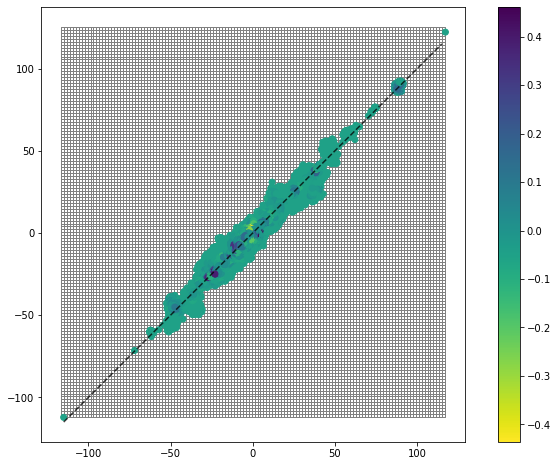

In [71]:
cell.plot(vmin=min(z), vmax=max(z), facecolor="none", edgecolor='grey', figsize=(12, 8))
ax = plt.scatter(x,y,c=z, cmap='viridis_r')
plt.plot([-115,115],[-115,115], 'k--', color='black', alpha=0.75)
plt.colorbar(ax)